## Run SecureLoop Scheduling

Run all three steps of scheduling and compare the effect of different scheduling algorithms (FIg. 11). For more detailed experiments for each step, check 1) `run_loopnest_scheduling.ipynb`, 2) `run_authblock_assignment.ipynb`, and 3) `run_simulated_annealing`.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import yaml
import shutil
from pathlib import Path

### 1. Define the accelerator architecture / parameters

First, define an architecture design. The code below generates/detects a new architecture configuration based on the template design at `designs/{design_name}/template`.

In [2]:
from utils import generate_arch_files, xml2mapping 

configuration_dict = {}

# template design (with constraints and memory hierarchy representing "dataflow")
configuration_dict['TEMPLATE_DESIGN'] = 'eyeriss_like'

# number of bits used for I/O/W; we assume integer
configuration_dict['WORDBITS'] = 16

# DRAM bandwidth setting: words / cycle (not bits / cycle)
configuration_dict['DRAM_READ_BANDWIDTH'] = 32
configuration_dict['DRAM_WRITE_BANDWIDTH'] = 32

# SRAM setting
# - do we have a single shared glb or multiple glbs for each datatype? 
# - for each glb (if shared, just one), define depth/width/#banks and bandwidths
configuration_dict['SRAM_SHARED'] = True
configuration_dict['SRAM_DEPTH'] = [2 ** 13]
configuration_dict['SRAM_WIDTH'] = [2 ** 7]
configuration_dict['SRAM_BANKS'] = [32]                     # SRAM width and SRAM banks define the maximum possible bandwidth
configuration_dict['SRAM_READ_BANDWIDTH'] = [32]
configuration_dict['SRAM_WRITE_BANDWIDTH'] = [32]

# PE array setting
# - shape of PE array X x Y
# - whether a PE has a shared scratchpad or separate scratchpads for each datatype
configuration_dict['PE_X'] = 14
configuration_dict['PE_Y'] = 12
configuration_dict['PE_SPAD_SHARED'] = False
configuration_dict['PE_SPAD_DEPTH'] = [192, 12, 16]         # Weight, IFmap, OFmap
configuration_dict['PE_SPAD_WIDTH'] = [16, 16, 16]

# Cryptographic engine setting
# - type of cryptographic engine + dram (LPDDR4 + AES-GCM)
# - cycle for AES-GCM 
# - whether the cryptographic engines are shared among all datatypes or assigned to each datatype
configuration_dict['CRYPT_ENGINE_TYPE'] = 'effective_lpddr4_aesgcm'
configuration_dict['CRYPT_ENGINE_CYCLE_PER_BLOCK'] = 11            # avg. cycle/128bit

configuration_dict['CRYPT_ENGINE_SHARED'] = False
configuration_dict['CRYPT_ENGINE_COUNT'] = [1, 1, 1]

configuration_dict['EFFECTIVE_CONSERVATIVE'] = True

# Create directory for this configuration if it doesn't exist already
# iterate through design folders to check if any pre-exisiting folder
design_dir = 'designs/{}'.format(configuration_dict['TEMPLATE_DESIGN'])
arch_dir = None
total_vers = 0
for path in os.listdir(design_dir):
    if path != 'template' and os.path.isdir(os.path.join(design_dir, path)):
        try:
            with open(os.path.join(design_dir, path, 'config.yaml'), 'r') as f:
                config_file = yaml.safe_load(f)
            total_vers += 1
            if config_file == configuration_dict:
                arch_dir = path
                print("Pre-existing folder found. Setting the arch_dir to {}".format(arch_dir))
                break
        except:
            print("No config.yaml file in the directory {}".format(str(os.path.join(design_dir, path))))
            
if arch_dir is None:
    arch_dir = 'ver{}'.format(total_vers)
    shutil.copytree(os.path.join(design_dir, 'template'), os.path.join(design_dir, arch_dir))
    with open(os.path.join(design_dir, arch_dir, 'config.yaml'), 'w') as f:
        _ = yaml.dump(configuration_dict, f)
    
    # create baseline and effective files
    generate_arch_files(os.path.join(design_dir, arch_dir, 'arch'), configuration_dict)
    
    # create scheduling / evaluation folder
    os.mkdir(os.path.join(design_dir, arch_dir, 'scheduling'))
    os.mkdir(os.path.join(design_dir, arch_dir, 'evaluation'))
    
    # create folders for baseline scheduling / evaluation
    os.mkdir(os.path.join(design_dir, arch_dir, 'baseline_scheduling'))
    os.mkdir(os.path.join(design_dir, arch_dir, 'baseline_evaluation'))

No config.yaml file in the directory designs/eyeriss_like/.ipynb_checkpoints
Pre-existing folder found. Setting the arch_dir to ver0


### 2. Define the DNN workload

Define a workload as PyTorch's torch.nn.module. Then, convert the workload to the Timeloop's workload format and extract unique layers and interlayer dependency information.

#### 2-1. Convert PyTorch workload to Timeloop workload (< 1 min)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as model_zoo

import pytorch2timeloop as pytorch2timeloop

# Note: this version only supports nn.Conv2d (both normal convs and depthwise/pointwise convs) and nn.Linear

# AlexNet
model_name = 'alexnet'
net = model_zoo.alexnet(pretrained=False)

# ResNet18
# model_name = 'resnet18'
# net = model_zoo.resnet18(pretrained=False)

# MobilenetV2
# model_name = 'mobilenet_v2'
# net = model_zoo.mobilenet_v2(pretrained=False)

# Input / Batch info
input_size = (3, 224, 224)
batch_size = 1

# print(net)

# Convert to timeloop workloads; stored in workloads/{model_name}_batch{batch_size}
top_dir = 'workloads'
sub_dir = '{}_batch{}'.format(model_name, batch_size)
exception_module_names = []

overwrite = False
if not os.path.exists(os.path.join(top_dir, sub_dir)) or overwrite:
    pytorch2timeloop.convert_model(
            net,
            input_size,
            batch_size,
            sub_dir,
            top_dir,
            True,
            exception_module_names
        )

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


#### 2-2. Extract unique layers (per-layer Timeloop loopnest scheduling only for unqiue layers) (< 1 min)

In [4]:
base_dir = Path(os.getcwd())
timeloop_dir = 'designs/{}/{}'.format(configuration_dict['TEMPLATE_DESIGN'], arch_dir)

n_layers = 0
layer_dict = {}
layer_duplicate_info = {}
unique_layers = []
for module in net.modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        n_layers += 1
        if n_layers not in layer_dict.keys():
            workload_path = os.path.join(base_dir, top_dir, sub_dir, '{}_layer{}.yaml'.format(sub_dir, n_layers))
            with open(workload_path, 'r') as f:
                workload_info = yaml.safe_load(f)
            layer_dict[n_layers] = workload_info
        
        # identify the earliest duplicate layer
        for key in range(1, n_layers):
            if layer_dict[key] == layer_dict[n_layers]:
                layer_duplicate_info[n_layers] = key
                break
        if n_layers not in layer_duplicate_info:
            unique_layers.append(n_layers)
            
# print(layer_duplicate_info)
# print(unique_layers)

#### 2-3. Extract interlayer dependency (1~10 min if running for the first time; < 1 min if saved yaml file is available)

We need to take care of interlayer dependencies. Since the layer number does not imply the actual layer order/dependency, and often multiple layers can be dependent on one layer and vice versa (e.g., residual connections), we create a back-propagation graph and determine the dependency from the graph. 

Depending on your accelerator architecture assumptions, some post-processing operations can be performed on-the-fly. Here, we assume that ReLU activation and batch normalization can be performed on-the-fly (thus, not affect the dependency), while pooling operations and adding multiple feature maps together (e.g., adding residual branches together) cannot be done on-the-fly (thus, break the depenency).

If you have different assumptions about the post-processing or using different versions of PyTorch with different backend operations, `BackpropGraph.isDependentLayer` has to be modified accordingly.

Define whether you want to ignore the interlayer dependency entirely (i.e., always use rehashing). Then, the dependency dictionary will ignore all interlayer dependency. 

Finally, constructing and analyzing the back-propagation grpah can take > 5 minutes for deep models like MobilenetV2. Since this dictionary has to be constructed only once per each model, we first search for existing dictionary. If not, then we generate a graph and create a dictionary and save it. 

*We provide the layer_info.yaml files in `workloads` - if you want to generate your own info, remove those yaml files*

In [5]:
from pytorch_layer_dependency_utils import BackpropGraph

workload_path_1 = os.path.join(base_dir, top_dir, sub_dir, 'layer_info_interlayer.yaml')
workload_path_2 = os.path.join(base_dir, top_dir, sub_dir, 'layer_info_ignore_interlayer.yaml') # we also need this for baseline

try:
    with open(workload_path_1, 'r') as f:
        layer_info = yaml.safe_load(f)
    with open(workload_path_2, 'r') as f:
        layer_info_ignore_interlayer = yaml.safe_load(f)
        
except:

    graph = BackpropGraph(net, [1, input_size[0], input_size[1], input_size[2]])
    consecutive_dict, dependent_dict = graph.get_dependency_info()

    # construct layer_info
    layer_info = {}
    layer_info_ignore_interlayer = {}
    for layer_idx in range(1, n_layers + 1):
        info = {}
        if layer_idx in unique_layers:
            info['layer_id_for_timeloop'] = layer_idx
        else:
            info['layer_id_for_timeloop'] = layer_duplicate_info[layer_idx]
        info['prev_layer'] = []
        info['next_layer'] = []
        info['dependent_prev_layer'] = []
        info['dependent_next_layer'] = []
        layer_info[layer_idx] = info
        layer_info_ignore_interlayer[layer_idx] = info

    for layer_idx in range(1, n_layers + 1):
        consecutive = consecutive_dict[layer_idx]
        dependent = dependent_dict[layer_idx]
        layer_info[layer_idx]['next_layer'].extend(consecutive)
        layer_info_ignore_interlayer[layer_idx]['next_layer'].extend(consecutive)
        for i in consecutive:
            layer_info[i]['prev_layer'].append(layer_idx)
            layer_info_ignore_interlayer[i]['prev_layer'].append(layer_idx)
        if len(dependent) > 0 and not ignore_interlayer:
            layer_info[layer_idx]['dependent_next_layer'].extend(dependent)   
            for i in dependent:
                layer_info[i]['dependent_prev_layer'].append(layer_idx)

    # for layer_idx in range(1, n_layers + 1):
    #     print(layer_idx, layer_info[layer_idx])

    # store therresults - this can take long for deep models like MobileNet..
    # f"{base_dir/top_dir/sub_dir/sub_dir}_layer{layer_id}.yaml "
    with open(workload_path_1, 'w') as f:
        _ = yaml.dump(layer_info, f)
    with open(workload_path_2, 'w') as f:
        _ = yaml.dump(layer_info_ignore_interlayer, f)


### 3. Define the top-k parameter and run timeloop-topk using the effective model (Step 1)

In [6]:
topk = 6
mapper_file_path = os.path.join(base_dir, timeloop_dir, 'mapper/mapper.yaml')
with open(mapper_file_path, 'r') as f:
    mapper_config = yaml.safe_load(f)
mapper_config['mapper']['topk'] = topk
with open(mapper_file_path, 'w') as f:
    _ = yaml.dump(mapper_config, f)

#### 3-1. Run timeloop-topk for all unique layers (~30 min)

In [7]:
import time

def get_cmd(workload_info, layer_id, base_dir, timeloop_dir, sub_dir, top_dir):
    cwd = f"{base_dir/timeloop_dir/'scheduling'/sub_dir/f'layer{layer_id}'}"
    if 'M' in workload_info['problem']['instance']:
        constraint_pth = base_dir/timeloop_dir/'constraints/*.yaml'
    else:
        # depthwise
        constraint_pth = base_dir/timeloop_dir/'constraints_dw/*.yaml'

    timeloopcmd = f"timeloop-mapper-topk " \
                  f"{base_dir/timeloop_dir/'arch/effective.yaml'} " \
                  f"{base_dir/timeloop_dir/'arch/components/*.yaml'} " \
                  f"{base_dir/timeloop_dir/'mapper/mapper.yaml'} " \
                  f"{constraint_pth} " \
                  f"{base_dir/top_dir/sub_dir/sub_dir}_layer{layer_id}.yaml "
    return [cwd, timeloopcmd]

cwd_list = []
cmd_list = []

for layer_id in unique_layers:
    workload_path = os.path.join(base_dir, top_dir, sub_dir, '{}_layer{}.yaml'.format(sub_dir, layer_id))
    with open(workload_path, 'r') as f:
        workload_info = yaml.safe_load(f)
    [cwd, cmd] = get_cmd(workload_info, layer_id, base_dir, timeloop_dir, sub_dir, top_dir)
    cwd_list.append(cwd)
    cmd_list.append(cmd)
    
if not os.path.exists(os.path.join(base_dir, timeloop_dir, 'scheduling', sub_dir)):
    os.mkdir(os.path.join(base_dir, timeloop_dir, 'scheduling', sub_dir))
    
start_time = time.time()
for cwd, cmd in zip(cwd_list, cmd_list):
    print("Executing cmd: {}".format(cmd))
    try:
        os.chdir(cwd)
    except:
        os.mkdir(cwd)
        os.chdir(cwd)
    os.system(cmd)
os.chdir(base_dir)

# Time this cell
print("Execution time: {}s".format(time.time() - start_time))

Executing cmd: timeloop-mapper-topk /home/workspace/designs/eyeriss_like/ver0/arch/effective.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/*.yaml /home/workspace/designs/eyeriss_like/ver0/mapper/mapper.yaml /home/workspace/designs/eyeriss_like/ver0/constraints/*.yaml /home/workspace/workloads/alexnet_batch1/alexnet_batch1_layer1.yaml 
  _______                __                
 /_  __(_)___ ___  ___  / /___  ____  ____ 
  / / / / __ `__ \/ _ \/ / __ \/ __ \/ __ \
 / / / / / / / / /  __/ / /_/ / /_/ / /_/ /
/_/ /_/_/ /_/ /_/\___/_/\____/\____/ .___/ 
                                  /_/      

Problem configuration complete.
execute:/usr/local/bin/accelergy /home/workspace/designs/eyeriss_like/ver0/arch/effective.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/smartbuffer_RF.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/smartbuffer_SRAM.yaml /home/workspace/designs/eyeriss_like/ver0/mapper/mapper.yaml /home/workspace/designs/eyeriss_lik

[  6] Utilization = 0.00 | pJ/Compute =  175.341 | L5[WIO] Q55 M4 - L4[IO] M4 P55 C3 M4X - L3[] Q1 S11Y - L2[I] Q1 - L1[W] R11 - L0[O] Q1 
[  3] Utilization = 0.33 | pJ/Compute =    8.256 | L5[WIO] Q11 C3 - L4[IO] M16 P55 Q5X - L3[] Q1 S11Y - L2[I] Q1 - L1[W] R11 - L0[O] M4 
[  7] Utilization = 0.10 | pJ/Compute =   14.435 | L5[WIO] Q55 M4 C3 - L4[IO] M4 P55 M4X - L3[] Q1 S11Y - L2[I] Q1 - L1[W] R11 - L0[O] Q1 
[  2] Utilization = 0.02 | pJ/Compute =   44.401 | L5[WIO] Q11 - L4[IO] M16 P55 C3 Q5X - L3[] Q1 S11Y - L2[I] Q1 - L1[W] R11 - L0[O] M4 
[  5] STATEMENT: 200 invalid mappings (200 fanout, 0 capacity) found since the last valid mapping, terminating search.
[  1] STATEMENT: 200 invalid mappings (200 fanout, 0 capacity) found since the last valid mapping, terminating search.
[  7] Utilization = 0.02 | pJ/Compute =   46.068 | L5[WIO] Q55 M32 C3 - L4[IO] P55 - L3[] Q1 S11Y - L2[I] Q1 - L1[W] R11 - L0[O] M2 
[  3] Utilization = 0.14 | pJ/Compute =   12.299 | L5[WIO] Q55 M2 C3 - L4[IO]

[  7] Utilization = 0.65 | pJ/Compute =    8.278 | L5[WIO] Q11 C3 - L4[IO] M16 P55 M2X Q5X - L3[] Q1 S11Y - L2[I] Q1 - L1[W] R11 - L0[O] M2 
[  3] Utilization = 0.65 | pJ/Compute =    6.908 | L5[WIO] Q11 C3 - L4[IO] M4 P55 M2X Q5X - L3[] Q1 S11Y - L2[I] Q1 - L1[W] R11 - L0[O] M8 
[  2] Utilization = 0.05 | pJ/Compute =   26.710 | L5[WIO] Q5 M4 - L4[IO] M4 P55 C3 Q11X - L3[] Q1 S11Y - L2[I] Q1 - L1[W] R11 - L0[O] M4 
[  2] Utilization = 0.05 | pJ/Compute =   26.710 | L5[WIO] Q5 M8 - L4[IO] M2 P55 C3 Q11X - L3[] Q1 S11Y - L2[I] Q1 - L1[W] R11 - L0[O] M4 
[  3] Utilization = 0.65 | pJ/Compute =   10.106 | L5[WIO] Q11 C3 - L4[IO] M32 P55 M2X Q5X - L3[] Q1 S11Y - L2[I] Q1 - L1[W] R11 - L0[O] Q1 
[  7] Utilization = 0.72 | pJ/Compute =    6.506 | L5[WIO] Q5 C3 - L4[IO] M4 P55 Q11X - L3[] Q1 S11Y - L2[I] Q1 - L1[W] R11 - L0[O] M16 
[  3] Utilization = 0.65 | pJ/Compute =    7.365 | L5[WIO] Q11 C3 - L4[IO] M8 P55 M2X Q5X - L3[] Q1 S11Y - L2[I] Q1 - L1[W] R11 - L0[O] M4 
[  3] Utilization = 0.7



Summary stats for best mapping found by mapper:
  Utilization = 0.72 | pJ/Compute =    6.506

Summary stats for best mapping found by mapper:
  Utilization = 0.72 | pJ/Compute =    6.957

Summary stats for best mapping found by mapper:
  Utilization = 0.72 | pJ/Compute =    7.860

Summary stats for best mapping found by mapper:
  Utilization = 0.72 | pJ/Compute =    9.665

Summary stats for best mapping found by mapper:
  Utilization = 0.66 | pJ/Compute =    6.956

Summary stats for best mapping found by mapper:
  Utilization = 0.66 | pJ/Compute =    7.407
Executing cmd: timeloop-mapper-topk /home/workspace/designs/eyeriss_like/ver0/arch/effective.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/*.yaml /home/workspace/designs/eyeriss_like/ver0/mapper/mapper.yaml /home/workspace/designs/eyeriss_like/ver0/constraints/*.yaml /home/workspace/workloads/alexnet_batch1/alexnet_batch1_layer2.yaml 
  _______                __                
 /_  __(_)___ ___  ___  / /___  ____ 

[  4] Utilization = 0.06 | pJ/Compute =   14.226 | L5[WIO] Q27 M8 C64 - L4[IO] P27 - L3[] Q1 M2Y S5Y - L2[I] Q1 - L1[W] R5 - L0[O] M12 
[  3] Utilization = 0.11 | pJ/Compute =   12.121 | L5[WIO] Q27 C32 - L4[IO] M16 P27 M3X - L3[] Q1 C2Y S5Y - L2[I] Q1 - L1[W] R5 - L0[O] M4 
[  2] Utilization = 0.09 | pJ/Compute =   12.097 | L5[WIO] Q27 C32 - L4[IO] M16 P27 M3X - L3[] Q1 S5Y - L2[I] Q1 - L1[W] R5 C2 - L0[O] M4 
[  4] Utilization = 0.11 | pJ/Compute =   13.514 | L5[WIO] Q27 M2 C64 - L4[IO] M16 P27 M6X - L3[] Q1 S5Y - L2[I] Q1 - L1[W] R5 - L0[O] Q1 
[  5] Utilization = 0.04 | pJ/Compute =   29.392 | L5[WIO] Q3 M4 C2 - L4[IO] M12 P27 C16 Q9X - L3[] Q1 S5Y - L2[I] Q1 - L1[W] R5 C2 - L0[O] M4 
[  7] Utilization = 0.00 | pJ/Compute =  172.773 | L5[WIO] Q27 M2 C4 - L4[IO] M16 P27 C4 M6X - L3[] Q1 C2Y S5Y - L2[I] Q1 - L1[W] R5 C2 - L0[O] Q1 
[  6] Utilization = 0.04 | pJ/Compute =   29.393 | L5[WIO] Q3 M4 C2 - L4[IO] M12 P27 C16 Q9X - L3[] Q1 C2Y S5Y - L2[I] Q1 - L1[W] R5 - L0[O] M4 
[  4] Uti

[  6] Utilization = 0.01 | pJ/Compute =   61.925 | L5[WIO] Q9 C4 - L4[IO] M12 P27 C8 M4X Q3X - L3[] Q1 M2Y S5Y - L2[I] Q1 - L1[W] R5 C2 - L0[O] M2 
[  2] Utilization = 0.18 | pJ/Compute =   10.333 | L5[WIO] Q9 M6 C32 - L4[IO] M16 P27 M2X Q3X - L3[] Q1 S5Y - L2[I] Q1 - L1[W] R5 C2 - L0[O] Q1 
[  3] Utilization = 0.28 | pJ/Compute =   10.358 | L5[WIO] Q9 M6 C32 - L4[IO] M16 P27 M2X Q3X - L3[] Q1 C2Y S5Y - L2[I] Q1 - L1[W] R5 - L0[O] Q1 
[  4] Utilization = 0.09 | pJ/Compute =   12.118 | L5[WIO] Q9 M16 C64 - L4[IO] M6 P27 Q3X - L3[] Q1 S5Y - L2[I] Q1 - L1[W] R5 - L0[O] M2 
[  7] Utilization = 0.00 | pJ/Compute =  169.484 | L5[WIO] Q27 M2 - L4[IO] M2 P27 C64 M3X - L3[] Q1 S5Y - L2[I] Q1 - L1[W] R5 - L0[O] M16 
[  5] Utilization = 0.01 | pJ/Compute =   61.834 | L5[WIO] Q9 M4 C8 - L4[IO] M2 P27 C4 Q3X - L3[] Q1 M2Y S5Y - L2[I] Q1 - L1[W] R5 C2 - L0[O] M12 
[  6] Utilization = 0.03 | pJ/Compute =   32.211 | L5[WIO] Q3 M48 C4 - L4[IO] P27 C8 Q9X - L3[] Q1 S5Y - L2[I] Q1 - L1[W] R5 C2 - L0[O] M

[  3] Utilization = 0.10 | pJ/Compute =   12.593 | L5[WIO] Q27 M4 C32 - L4[IO] M2 P27 M6X - L3[] Q1 C2Y S5Y - L2[I] Q1 - L1[W] R5 - L0[O] M4 
[  2] Utilization = 0.27 | pJ/Compute =    8.547 | L5[WIO] Q3 M3 C32 - L4[IO] M32 P27 Q9X - L3[] Q1 S5Y - L2[I] Q1 - L1[W] R5 C2 - L0[O] M2 
[  6] Utilization = 0.07 | pJ/Compute =   19.454 | L5[WIO] Q9 M96 C32 - L4[IO] P27 Q3X - L3[] Q1 S5Y - L2[I] Q1 - L1[W] R5 C2 - L0[O] M2 
[  0] Utilization = 0.18 | pJ/Compute =    9.603 | L5[WIO] Q9 M2 C64 - L4[IO] M24 P27 M2X Q3X - L3[] Q1 S5Y - L2[I] Q1 - L1[W] R5 - L0[O] M2 
[  3] Utilization = 0.04 | pJ/Compute =   43.614 | L5[WIO] Q3 M8 - L4[IO] M24 P27 C64 Q9X - L3[] Q1 S5Y - L2[I] Q1 - L1[W] R5 - L0[O] Q1 
[  5] Utilization = 0.18 | pJ/Compute =    9.387 | L5[WIO] Q9 M8 C16 - L4[IO] M8 P27 Q3X - L3[] Q1 C2Y S5Y - L2[I] Q1 - L1[W] R5 C2 - L0[O] M3 
[  3] Utilization = 0.10 | pJ/Compute =   12.788 | L5[WIO] Q27 M4 C32 - L4[IO] M4 P27 M6X - L3[] Q1 C2Y S5Y - L2[I] Q1 - L1[W] R5 - L0[O] M2 
[  6] Utiliza

[  4] Utilization = 0.27 | pJ/Compute =    7.345 | L5[WIO] Q3 M2 C64 - L4[IO] M6 P27 Q9X - L3[] Q1 S5Y - L2[I] Q1 - L1[W] R5 - L0[O] M16 
[  2] Utilization = 0.18 | pJ/Compute =    8.351 | L5[WIO] Q9 M3 C32 - L4[IO] M8 P27 Q3X - L3[] Q1 M2Y S5Y - L2[I] Q1 - L1[W] R5 C2 - L0[O] M4 
[  6] Utilization = 0.28 | pJ/Compute =    8.383 | L5[WIO] Q9 M6 C32 - L4[IO] M2 P27 M4X Q3X - L3[] Q1 S5Y - L2[I] Q1 - L1[W] R5 C2 - L0[O] M4 
[  2] Utilization = 0.28 | pJ/Compute =    9.242 | L5[WIO] Q9 M6 C32 - L4[IO] M8 P27 M2X Q3X - L3[] Q1 M2Y S5Y - L2[I] Q1 - L1[W] R5 C2 - L0[O] Q1 
[  0] Utilization = 0.54 | pJ/Compute =    9.243 | L5[WIO] Q3 C64 - L4[IO] M96 P27 Q9X - L3[] Q1 M2Y S5Y - L2[I] Q1 - L1[W] R5 - L0[O] Q1 
[  1] Utilization = 0.35 | pJ/Compute =    8.377 | L5[WIO] Q3 M24 C16 - L4[IO] M2 P27 Q9X - L3[] Q1 C2Y S5Y - L2[I] Q1 - L1[W] R5 C2 - L0[O] M4 
[  4] Utilization = 0.27 | pJ/Compute =    7.597 | L5[WIO] Q3 M6 C64 - L4[IO] M2 P27 Q9X - L3[] Q1 S5Y - L2[I] Q1 - L1[W] R5 - L0[O] M16 
[  6

[  0] Utilization = 0.54 | pJ/Compute =    7.752 | L5[WIO] Q3 C64 - L4[IO] M32 P27 Q9X - L3[] Q1 M2Y S5Y - L2[I] Q1 - L1[W] R5 - L0[O] M3 
[  4] Utilization = 0.54 | pJ/Compute =    7.633 | L5[WIO] Q3 M8 C64 - L4[IO] P27 Q9X - L3[] Q1 M2Y S5Y - L2[I] Q1 - L1[W] R5 - L0[O] M12 
[  6] Utilization = 0.34 | pJ/Compute =    7.875 | L5[WIO] Q9 C32 - L4[IO] M12 P27 M2X Q3X - L3[] Q1 M2Y S5Y - L2[I] Q1 - L1[W] R5 C2 - L0[O] M4 
[  0] Utilization = 0.54 | pJ/Compute =    9.558 | L5[WIO] Q3 M6 C64 - L4[IO] M16 P27 Q9X - L3[] Q1 M2Y S5Y - L2[I] Q1 - L1[W] R5 - L0[O] Q1 
[  0] Utilization = 0.54 | pJ/Compute =    7.209 | L5[WIO] Q3 M2 C64 - L4[IO] M3 P27 Q9X - L3[] Q1 M2Y S5Y - L2[I] Q1 - L1[W] R5 - L0[O] M16 
[  5] Utilization = 0.54 | pJ/Compute =    6.416 | L5[WIO] Q3 M6 C16 - L4[IO] M2 P27 Q9X - L3[] Q1 C2Y S5Y - L2[I] Q1 - L1[W] R5 C2 - L0[O] M16 
[  1] Utilization = 0.54 | pJ/Compute =    6.101 | L5[WIO] Q3 C16 - L4[IO] M12 P27 Q9X - L3[] Q1 C2Y S5Y - L2[I] Q1 - L1[W] R5 C2 - L0[O] M16 
[  2



Summary stats for best mapping found by mapper:
  Utilization = 0.54 | pJ/Compute =    6.101

Summary stats for best mapping found by mapper:
  Utilization = 0.54 | pJ/Compute =    6.351

Summary stats for best mapping found by mapper:
  Utilization = 0.54 | pJ/Compute =    6.414

Summary stats for best mapping found by mapper:
  Utilization = 0.54 | pJ/Compute =    6.416

Summary stats for best mapping found by mapper:
  Utilization = 0.54 | pJ/Compute =    6.441

Summary stats for best mapping found by mapper:
  Utilization = 0.54 | pJ/Compute =    6.554
Executing cmd: timeloop-mapper-topk /home/workspace/designs/eyeriss_like/ver0/arch/effective.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/*.yaml /home/workspace/designs/eyeriss_like/ver0/mapper/mapper.yaml /home/workspace/designs/eyeriss_like/ver0/constraints/*.yaml /home/workspace/workloads/alexnet_batch1/alexnet_batch1_layer3.yaml 
  _______                __                
 /_  __(_)___ ___  ___  / /___  ____ 

[  0] Utilization = 0.00 | pJ/Compute =  188.163 | L5[WIO] Q13 - L4[IO] M384 P13 C48 - L3[] Q1 S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] Q1 
[  7] Utilization = 0.00 | pJ/Compute =  169.860 | L5[WIO] Q13 M4 - L4[IO] M4 P13 C24 M4X - L3[] Q1 C4Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M6 
[  2] Utilization = 0.00 | pJ/Compute =  188.163 | L5[WIO] Q13 - L4[IO] M384 P13 C48 - L3[] Q1 C4Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] Q1 
[  4] Utilization = 0.00 | pJ/Compute =  170.231 | L5[WIO] Q13 M8 - L4[IO] M3 P13 C96 - L3[] Q1 C2Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] M16 
[  1] Utilization = 0.00 | pJ/Compute =  188.163 | L5[WIO] Q13 - L4[IO] M384 P13 C48 - L3[] Q1 C2Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] Q1 
[  3] Utilization = 0.00 | pJ/Compute =  182.637 | L5[WIO] Q13 M48 C3 - L4[IO] M2 P13 C32 M4X - L3[] Q1 C2Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] Q1 
[  5] Utilization = 0.00 | pJ/Compute =  182.637 | L5[WIO] Q13 M48 C3 - L4[IO] M2 P13 C8 M4X - L3[] Q1 C2Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] Q1 
[  4] Uti

[  0] Utilization = 0.06 | pJ/Compute =   21.587 | L5[WIO] M2 C48 - L4[IO] M16 P13 C4 Q13X - L3[] Q1 M3Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] M4 
[  2] Utilization = 0.06 | pJ/Compute =   19.414 | L5[WIO] M12 - L4[IO] P13 C32 Q13X - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 C3 - L0[O] M16 
[  4] Utilization = 0.06 | pJ/Compute =   19.683 | L5[WIO] M3 C6 - L4[IO] M4 P13 C16 Q13X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M8 
[  0] Utilization = 0.06 | pJ/Compute =   38.052 | L5[WIO] M24 - L4[IO] M16 P13 C48 Q13X - L3[] Q1 S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] Q1 
[  6] Utilization = 0.05 | pJ/Compute =   18.485 | L5[WIO] Q13 M2 C24 - L4[IO] M8 P13 M3X - L3[] Q1 C2Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] M8 
[  1] Utilization = 0.00 | pJ/Compute =  174.085 | L5[WIO] Q13 C4 - L4[IO] M96 P13 C16 - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 C3 - L0[O] Q1 
[  1] Utilization = 0.00 | pJ/Compute =  172.095 | L5[WIO] Q13 M4 C6 - L4[IO] M12 P13 C8 - L3[] Q1 S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] M8 


[  2] Utilization = 0.06 | pJ/Compute =   24.279 | L5[WIO] M2 C24 - L4[IO] M48 P13 C2 Q13X - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M2 
[  5] Utilization = 0.05 | pJ/Compute =   22.703 | L5[WIO] M8 C8 - L4[IO] M8 P13 C6 Q13X - L3[] Q1 M2Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] M3 
[  7] Utilization = 0.18 | pJ/Compute =   13.557 | L5[WIO] M48 C32 - L4[IO] M4 P13 Q13X - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 C3 - L0[O] Q1 
[  2] Utilization = 0.06 | pJ/Compute =   19.743 | L5[WIO] M2 C3 - L4[IO] M8 P13 C32 Q13X - L3[] Q1 M3Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M8 
[  3] Utilization = 0.05 | pJ/Compute =   20.397 | L5[WIO] M6 C2 - L4[IO] M4 P13 C96 Q13X - L3[] Q1 M2Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] M8 
[  4] Utilization = 0.06 | pJ/Compute =   19.780 | L5[WIO] Q13 C96 - L4[IO] M8 P13 M4X - L3[] Q1 M2Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M6 
[  3] Utilization = 0.05 | pJ/Compute =   19.168 | L5[WIO] Q13 M4 C48 - L4[IO] P13 M12X - L3[] Q1 M2Y S3Y - L2[I] Q1 - L1[W] R3 C4

[  2] Utilization = 0.06 | pJ/Compute =   22.053 | L5[WIO] M32 - L4[IO] M2 P13 C32 Q13X - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 C3 - L0[O] M3 
[  0] Utilization = 0.06 | pJ/Compute =   20.008 | L5[WIO] M4 - L4[IO] M6 P13 C48 Q13X - L3[] Q1 S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] M16 
[  6] Utilization = 0.06 | pJ/Compute =   20.409 | L5[WIO] M32 - L4[IO] P13 C192 Q13X - L3[] Q1 S3Y - L2[I] Q1 - L1[W] R3 - L0[O] M12 
[  2] Utilization = 0.06 | pJ/Compute =   21.211 | L5[WIO] M3 - L4[IO] M16 P13 C32 Q13X - L3[] Q1 C2Y S3Y - L2[I] Q1 - L1[W] R3 C3 - L0[O] M8 
[  4] Utilization = 0.46 | pJ/Compute =    8.421 | L5[WIO] C96 - L4[IO] M24 P13 Q13X - L3[] Q1 M2Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M8 
[  0] Utilization = 0.48 | pJ/Compute =    9.485 | L5[WIO] M8 C32 - L4[IO] M16 P13 Q13X - L3[] Q1 C3Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M3 
[  7] Utilization = 0.65 | pJ/Compute =    7.343 | L5[WIO] M2 C24 - L4[IO] M24 P13 Q13X - L3[] Q1 C4Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M8 
[  3] Util

[  0] Utilization = 0.58 | pJ/Compute =    7.970 | L5[WIO] M4 C32 - L4[IO] M16 P13 Q13X - L3[] Q1 C3Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M6 
[  3] Utilization = 0.46 | pJ/Compute =    8.029 | L5[WIO] M8 C64 - L4[IO] M2 P13 Q13X - L3[] Q1 M2Y S3Y - L2[I] Q1 - L1[W] R3 C3 - L0[O] M12 
[  1] Utilization = 0.29 | pJ/Compute =   11.374 | L5[WIO] M24 C12 - L4[IO] M8 P13 Q13X - L3[] Q1 C4Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] M2 
[  0] Utilization = 0.61 | pJ/Compute =    7.129 | L5[WIO] M3 C32 - L4[IO] M8 P13 Q13X - L3[] Q1 C3Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M16 
[  4] STATEMENT: 200 suboptimal mappings found since the last upgrade, terminating search.
[  0] Utilization = 0.61 | pJ/Compute =    7.592 | L5[WIO] M3 C32 - L4[IO] M16 P13 Q13X - L3[] Q1 C3Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M8 
[  1] Utilization = 0.41 | pJ/Compute =    7.852 | L5[WIO] M12 C16 - L4[IO] M4 P13 Q13X - L3[] Q1 C4Y S3Y - L2[I] Q1 - L1[W] R3 C3 - L0[O] M8 
[  3] Utilization = 0.48 | pJ/Compute =    7.875 | 



Summary stats for best mapping found by mapper:
  Utilization = 0.69 | pJ/Compute =    8.463

Summary stats for best mapping found by mapper:
  Utilization = 0.65 | pJ/Compute =    6.880

Summary stats for best mapping found by mapper:
  Utilization = 0.65 | pJ/Compute =    7.343

Summary stats for best mapping found by mapper:
  Utilization = 0.65 | pJ/Compute =    7.890

Summary stats for best mapping found by mapper:
  Utilization = 0.65 | pJ/Compute =    8.456

Summary stats for best mapping found by mapper:
  Utilization = 0.65 | pJ/Compute =    8.983
Executing cmd: timeloop-mapper-topk /home/workspace/designs/eyeriss_like/ver0/arch/effective.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/*.yaml /home/workspace/designs/eyeriss_like/ver0/mapper/mapper.yaml /home/workspace/designs/eyeriss_like/ver0/constraints/*.yaml /home/workspace/workloads/alexnet_batch1/alexnet_batch1_layer4.yaml 
  _______                __                
 /_  __(_)___ ___  ___  / /___  ____ 

[  2] Utilization = 0.00 | pJ/Compute =  169.188 | L5[WIO] Q13 C3 - L4[IO] P13 C64 M8X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M8 
[  1] Utilization = 0.00 | pJ/Compute =  169.726 | L5[WIO] Q13 C2 - L4[IO] M8 P13 C96 M4X - L3[] Q1 M2Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M4 
[  6] Utilization = 0.00 | pJ/Compute =  179.201 | L5[WIO] Q13 M2 C12 - L4[IO] M64 P13 C32 - L3[] Q1 M2Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] Q1 
[  0] Utilization = 0.00 | pJ/Compute =  178.803 | L5[WIO] Q13 M2 - L4[IO] M64 P13 C192 - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] Q1 
[  4] Utilization = 0.00 | pJ/Compute =  175.800 | L5[WIO] Q13 M8 C2 - L4[IO] M8 P13 C32 - L3[] Q1 C2Y S3Y - L2[I] Q1 - L1[W] R3 C3 - L0[O] M4 
[  3] Utilization = 0.00 | pJ/Compute =  179.201 | L5[WIO] Q13 M2 C12 - L4[IO] M64 P13 C8 - L3[] Q1 M2Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] Q1 
[  7] Utilization = 0.00 | pJ/Compute =  179.201 | L5[WIO] Q13 M2 C12 - L4[IO] M64 P13 C16 - L3[] Q1 M2Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L

[  4] Utilization = 0.00 | pJ/Compute =  169.395 | L5[WIO] Q13 C16 - L4[IO] M2 P13 C8 M8X - L3[] Q1 S3Y - L2[I] Q1 - L1[W] R3 C3 - L0[O] M16 
[  2] Utilization = 0.46 | pJ/Compute =    8.908 | L5[WIO] C192 - L4[IO] M32 P13 Q13X - L3[] Q1 C2Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] M8 
[  1] Utilization = 0.23 | pJ/Compute =    8.866 | L5[WIO] C192 - L4[IO] M32 P13 Q13X - L3[] Q1 S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M8 
[  6] Utilization = 0.04 | pJ/Compute =   35.324 | L5[WIO] M64 C16 - L4[IO] M2 P13 C12 Q13X - L3[] Q1 M2Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] Q1 
[  1] Utilization = 0.18 | pJ/Compute =   18.606 | L5[WIO] M32 C192 - L4[IO] M8 P13 Q13X - L3[] Q1 S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] Q1 
[  0] Utilization = 0.00 | pJ/Compute =  190.259 | L5[WIO] Q13 M8 C4 - L4[IO] M32 P13 C8 - L3[] Q1 C4Y S3Y - L2[I] Q1 - L1[W] R3 C3 - L0[O] Q1 
[  4] Utilization = 0.04 | pJ/Compute =   35.324 | L5[WIO] M64 C16 - L4[IO] M2 P13 C8 Q13X - L3[] Q1 M2Y S3Y - L2[I] Q1 - L1[W] R3 C3 - L0[O] Q1 
[  2] 

[  5] Utilization = 0.05 | pJ/Compute =   25.349 | L5[WIO] M16 C16 - L4[IO] M4 P13 C2 Q13X - L3[] Q1 C3Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] M4 
[  6] Utilization = 0.05 | pJ/Compute =   31.084 | L5[WIO] M16 C96 - L4[IO] M8 P13 C2 Q13X - L3[] Q1 C2Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] M2 
[  4] Utilization = 0.29 | pJ/Compute =   12.193 | L5[WIO] M16 C96 - L4[IO] M8 P13 Q13X - L3[] Q1 C4Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] M2 
[  4] Utilization = 0.23 | pJ/Compute =   14.560 | L5[WIO] M8 C384 - L4[IO] M16 P13 Q13X - L3[] Q1 S3Y - L2[I] Q1 - L1[W] R3 - L0[O] M2 
[  6] Utilization = 0.05 | pJ/Compute =   24.443 | L5[WIO] M4 C48 - L4[IO] M16 P13 C2 Q13X - L3[] Q1 S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] M4 
[  1] Utilization = 0.67 | pJ/Compute =    9.860 | L5[WIO] C192 - L4[IO] M64 P13 Q13X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] Q1 
[  6] Utilization = 0.05 | pJ/Compute =   22.098 | L5[WIO] M8 C16 - L4[IO] M4 P13 C4 Q13X - L3[] Q1 C2Y S3Y - L2[I] Q1 - L1[W] R3 C3 - L0[O] M8 
[  3] 

[  2] Utilization = 0.29 | pJ/Compute =    9.366 | L5[WIO] M16 C96 - L4[IO] M2 P13 Q13X - L3[] Q1 M2Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] M4 
[  0] Utilization = 0.06 | pJ/Compute =   21.645 | L5[WIO] M2 C32 - L4[IO] M16 P13 C6 Q13X - L3[] Q1 S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M8 
[  3] Utilization = 0.67 | pJ/Compute =    7.252 | L5[WIO] C48 - L4[IO] M32 P13 Q13X - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] M4 
[  6] Utilization = 0.06 | pJ/Compute =   20.382 | L5[WIO] C32 - L4[IO] M16 P13 C4 Q13X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 C3 - L0[O] M4 
[  6] Utilization = 0.06 | pJ/Compute =   23.732 | L5[WIO] C8 - L4[IO] M64 P13 C16 Q13X - L3[] Q1 M2Y S3Y - L2[I] Q1 - L1[W] R3 C3 - L0[O] M2 
[  0] Utilization = 0.06 | pJ/Compute =   19.667 | L5[WIO] M2 C16 - L4[IO] M4 P13 C24 Q13X - L3[] Q1 M2Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] M16 
[  6] Utilization = 0.06 | pJ/Compute =   19.173 | L5[WIO] C8 - L4[IO] M4 P13 C16 Q13X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 C3 - L0[O] M16

[  5] Utilization = 0.61 | pJ/Compute =   10.353 | L5[WIO] M2 C64 - L4[IO] M64 P13 Q13X - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 C3 - L0[O] Q1 
[  2] Utilization = 0.67 | pJ/Compute =    9.856 | L5[WIO] C192 - L4[IO] M64 P13 Q13X - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] M2 
[  0] Utilization = 0.67 | pJ/Compute =    7.694 | L5[WIO] C128 - L4[IO] M16 P13 Q13X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 C3 - L0[O] M4 
[  0] Utilization = 0.41 | pJ/Compute =    8.191 | L5[WIO] M8 C128 - L4[IO] P13 Q13X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 C3 - L0[O] M8 
[  2] Utilization = 0.61 | pJ/Compute =    7.915 | L5[WIO] M2 C96 - L4[IO] M16 P13 Q13X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] M2 
[  4] Utilization = 0.61 | pJ/Compute =    7.943 | L5[WIO] M2 C96 - L4[IO] M16 P13 Q13X - L3[] Q1 C4Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] M8 
[  0] Utilization = 0.61 | pJ/Compute =    7.559 | L5[WIO] M2 C128 - L4[IO] M4 P13 Q13X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 C3 - L0[O] M8 
[  3



Summary stats for best mapping found by mapper:
  Utilization = 0.67 | pJ/Compute =    6.971

Summary stats for best mapping found by mapper:
  Utilization = 0.67 | pJ/Compute =    7.252

Summary stats for best mapping found by mapper:
  Utilization = 0.67 | pJ/Compute =    7.438

Summary stats for best mapping found by mapper:
  Utilization = 0.67 | pJ/Compute =    7.694

Summary stats for best mapping found by mapper:
  Utilization = 0.67 | pJ/Compute =    7.808

Summary stats for best mapping found by mapper:
  Utilization = 0.67 | pJ/Compute =    7.810
Executing cmd: timeloop-mapper-topk /home/workspace/designs/eyeriss_like/ver0/arch/effective.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/*.yaml /home/workspace/designs/eyeriss_like/ver0/mapper/mapper.yaml /home/workspace/designs/eyeriss_like/ver0/constraints/*.yaml /home/workspace/workloads/alexnet_batch1/alexnet_batch1_layer5.yaml 
  _______                __                
 /_  __(_)___ ___  ___  / /___  ____ 

[  5] Utilization = 0.00 | pJ/Compute =  178.832 | L5[WIO] Q13 M2 - L4[IO] M64 P13 C256 - L3[] Q1 M2Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] Q1 
[  6] Utilization = 0.00 | pJ/Compute =  169.211 | L5[WIO] Q13 C2 - L4[IO] P13 C32 M8X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] M8 
[  7] Utilization = 0.00 | pJ/Compute =  171.703 | L5[WIO] Q13 M8 - L4[IO] M4 P13 C128 M2X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] Q1 
[  3] Utilization = 0.05 | pJ/Compute =   21.584 | L5[WIO] M4 C4 - L4[IO] M8 P13 C32 Q13X - L3[] Q1 S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M8 
[  4] Utilization = 0.00 | pJ/Compute =  179.634 | L5[WIO] Q13 M2 C32 - L4[IO] M64 P13 C2 - L3[] Q1 M2Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] Q1 
[  2] Utilization = 0.00 | pJ/Compute =  176.762 | L5[WIO] Q13 M16 C64 - L4[IO] M2 P13 C4 - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] M2 
[  1] Utilization = 0.05 | pJ/Compute =   22.075 | L5[WIO] Q13 M2 C32 - L4[IO] M64 P13 - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] Q1

[  1] Utilization = 0.06 | pJ/Compute =   38.285 | L5[WIO] M2 C8 - L4[IO] M128 P13 C16 Q13X - L3[] Q1 C2Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] Q1 
[  4] Utilization = 0.04 | pJ/Compute =   35.443 | L5[WIO] M64 C16 - L4[IO] M2 P13 C8 Q13X - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] Q1 
[  5] Utilization = 0.05 | pJ/Compute =   21.051 | L5[WIO] M8 C16 - L4[IO] M2 P13 C8 Q13X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M4 
[  0] Utilization = 0.06 | pJ/Compute =   38.282 | L5[WIO] M2 C8 - L4[IO] M128 P13 C16 Q13X - L3[] Q1 S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] Q1 
[  1] Utilization = 0.06 | pJ/Compute =   17.849 | L5[WIO] Q13 C16 - L4[IO] M2 P13 M8X - L3[] Q1 C4Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] M16 
[  3] Utilization = 0.03 | pJ/Compute =   28.407 | L5[WIO] Q13 M32 C32 - L4[IO] M2 P13 - L3[] Q1 C4Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M4 
[  4] Utilization = 0.04 | pJ/Compute =   45.226 | L5[WIO] M64 C32 - L4[IO] M4 P13 C2 Q13X - L3[] Q1 C2Y S3Y - L2[I] Q1 - L1[W] R3 C2 - 

[  5] Utilization = 0.46 | pJ/Compute =    9.943 | L5[WIO] M2 C128 - L4[IO] M32 P13 Q13X - L3[] Q1 M2Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M2 
[  4] Utilization = 0.06 | pJ/Compute =   20.151 | L5[WIO] M2 C2 - L4[IO] M8 P13 C64 Q13X - L3[] Q1 M2Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M8 
[  0] Utilization = 0.06 | pJ/Compute =   22.396 | L5[WIO] M2 C64 - L4[IO] M16 P13 C2 Q13X - L3[] Q1 S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M8 
[  2] Utilization = 0.06 | pJ/Compute =   22.396 | L5[WIO] M2 C64 - L4[IO] M16 P13 C4 Q13X - L3[] Q1 S3Y - L2[I] Q1 - L1[W] R3 - L0[O] M8 
[  6] Utilization = 0.06 | pJ/Compute =   21.217 | L5[WIO] M8 - L4[IO] M4 P13 C128 Q13X - L3[] Q1 S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M8 
[  5] Utilization = 0.41 | pJ/Compute =   12.801 | L5[WIO] M8 C256 - L4[IO] M8 P13 Q13X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] Q1 
[  7] Utilization = 0.05 | pJ/Compute =   20.121 | L5[WIO] Q13 M2 C128 - L4[IO] M2 P13 M8X - L3[] Q1 C2Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] M8 
[  0] Ut

[  4] Utilization = 0.67 | pJ/Compute =   12.064 | L5[WIO] C256 - L4[IO] M64 P13 Q13X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] Q1 
[  0] Utilization = 0.29 | pJ/Compute =   13.643 | L5[WIO] M16 C256 - L4[IO] M4 P13 Q13X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] Q1 
[  6] Utilization = 0.06 | pJ/Compute =   21.132 | L5[WIO] C64 - L4[IO] M16 P13 C4 Q13X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] M4 
[  1] Utilization = 0.67 | pJ/Compute =    7.354 | L5[WIO] C64 - L4[IO] M16 P13 Q13X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] M4 
[  7] Utilization = 0.61 | pJ/Compute =    8.310 | L5[WIO] M2 C128 - L4[IO] M4 P13 Q13X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M8 
[  6] Utilization = 0.41 | pJ/Compute =    7.538 | L5[WIO] M8 C32 - L4[IO] M2 P13 Q13X - L3[] Q1 C2Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] M16 
[  7] Utilization = 0.41 | pJ/Compute =    7.559 | L5[WIO] M8 C32 - L4[IO] M2 P13 Q13X - L3[] Q1 C4Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M16 
[  6] Utiliz

[  2] Utilization = 0.61 | pJ/Compute =   10.491 | L5[WIO] M2 C256 - L4[IO] M4 P13 Q13X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] M8 
[  2] Utilization = 0.61 | pJ/Compute =    7.468 | L5[WIO] M2 C64 - L4[IO] M8 P13 Q13X - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M8 
[  1] Utilization = 0.46 | pJ/Compute =    7.448 | L5[WIO] M2 C64 - L4[IO] M8 P13 Q13X - L3[] Q1 M2Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] M8 
[  7] Utilization = 0.53 | pJ/Compute =    6.849 | L5[WIO] M4 C16 - L4[IO] M4 P13 Q13X - L3[] Q1 C4Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] M16 
[  1] Utilization = 0.61 | pJ/Compute =   10.371 | L5[WIO] M2 C256 - L4[IO] M2 P13 Q13X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] M16 
[  3] Utilization = 0.61 | pJ/Compute =    6.639 | L5[WIO] M2 C16 - L4[IO] M8 P13 Q13X - L3[] Q1 C4Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] M16 
[  2] Utilization = 0.46 | pJ/Compute =    7.811 | L5[WIO] C64 - L4[IO] M32 P13 Q13X - L3[] Q1 M2Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] M4 
[  6]



Summary stats for best mapping found by mapper:
  Utilization = 0.67 | pJ/Compute =    7.276

Summary stats for best mapping found by mapper:
  Utilization = 0.67 | pJ/Compute =    7.354

Summary stats for best mapping found by mapper:
  Utilization = 0.67 | pJ/Compute =    7.363

Summary stats for best mapping found by mapper:
  Utilization = 0.67 | pJ/Compute =    7.399

Summary stats for best mapping found by mapper:
  Utilization = 0.67 | pJ/Compute =    7.834

Summary stats for best mapping found by mapper:
  Utilization = 0.67 | pJ/Compute =    7.831
Executing cmd: timeloop-mapper-topk /home/workspace/designs/eyeriss_like/ver0/arch/effective.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/*.yaml /home/workspace/designs/eyeriss_like/ver0/mapper/mapper.yaml /home/workspace/designs/eyeriss_like/ver0/constraints/*.yaml /home/workspace/workloads/alexnet_batch1/alexnet_batch1_layer6.yaml 
  _______                __                
 /_  __(_)___ ___  ___  / /___  ____ 

[  7] Utilization = 0.00 | pJ/Compute =  175.658 | L5[WIO] M128 C4 - L4[IO] M2 C64 - L3[] Q1 C6Y - L2[I] Q1 - L1[W] C6 - L0[O] M16 
[  5] Utilization = 0.00 | pJ/Compute =  175.658 | L5[WIO] M128 C4 - L4[IO] M2 C64 - L3[] Q1 C3Y - L2[I] Q1 - L1[W] C12 - L0[O] M16 
[  6] Utilization = 0.00 | pJ/Compute =  175.658 | L5[WIO] M128 C4 - L4[IO] M2 C64 - L3[] Q1 C4Y - L2[I] Q1 - L1[W] C9 - L0[O] M16 
[  2] Utilization = 0.00 | pJ/Compute =  175.659 | L5[WIO] M128 C4 - L4[IO] M2 C192 - L3[] Q1 C12Y - L2[I] Q1 - L1[W] Q1 - L0[O] M16 
[  4] Utilization = 0.00 | pJ/Compute =  171.924 | L5[WIO] M8 C48 - L4[IO] M64 C16 M8X - L3[] Q1 C6Y - L2[I] Q1 - L1[W] C2 - L0[O] Q1 
[  3] Utilization = 0.00 | pJ/Compute =  171.921 | L5[WIO] M8 C48 - L4[IO] M64 C16 M8X - L3[] Q1 C4Y - L2[I] Q1 - L1[W] C3 - L0[O] Q1 
[  5] Utilization = 0.00 | pJ/Compute =  169.596 | L5[WIO] M16 C2304 - L4[IO] Q1 M8X - L3[] Q1 M8Y - L2[I] Q1 - L1[W] C4 - L0[O] M4 
[  1] Utilization = 0.00 | pJ/Compute =  175.658 | L5[WIO] M128 C4

[  7] Utilization = 0.00 | pJ/Compute =  169.848 | L5[WIO] M2 C96 - L4[IO] M64 C32 - L3[] Q1 M2Y - L2[I] Q1 - L1[W] C3 - L0[O] M16 
[  3] Utilization = 0.00 | pJ/Compute =  169.861 | L5[WIO] M2 C96 - L4[IO] M64 C16 - L3[] Q1 M2Y C6Y - L2[I] Q1 - L1[W] Q1 - L0[O] M16 
[  3] Utilization = 0.00 | pJ/Compute =  169.866 | L5[WIO] M8 C12 - L4[IO] M16 C96 M4X - L3[] Q1 M4Y C2Y - L2[I] Q1 - L1[W] C4 - L0[O] M2 
[  1] Utilization = 0.00 | pJ/Compute =  169.095 | L5[WIO] C32 - L4[IO] M32 C18 M8X - L3[] Q1 C8Y - L2[I] Q1 - L1[W] C2 - L0[O] M16 
[  3] Utilization = 0.00 | pJ/Compute =  169.301 | L5[WIO] M8 C8 - L4[IO] M4 C12 M8X - L3[] Q1 C8Y - L2[I] Q1 - L1[W] C12 - L0[O] M16 
[  5] Utilization = 0.00 | pJ/Compute =  169.445 | L5[WIO] M8 C32 - L4[IO] M4 C48 M4X - L3[] Q1 M8Y - L2[I] Q1 - L1[W] C6 - L0[O] M4 
[  2] Utilization = 0.00 | pJ/Compute =  169.854 | L5[WIO] M2 C96 - L4[IO] M64 C16 - L3[] Q1 M2Y C3Y - L2[I] Q1 - L1[W] C2 - L0[O] M16 
[  4] Utilization = 0.00 | pJ/Compute =  170.512 | L5[W

[  0] Utilization = 0.00 | pJ/Compute =  169.529 | L5[WIO] C6 - L4[IO] M128 C1536 M8X - L3[] Q1 M2Y - L2[I] Q1 - L1[W] Q1 - L0[O] M2 
[  5] Utilization = 0.00 | pJ/Compute =  169.108 | L5[WIO] M8 - L4[IO] M8 C1536 - L3[] Q1 M4Y C2Y - L2[I] Q1 - L1[W] C3 - L0[O] M16 
[  2] Utilization = 0.00 | pJ/Compute =  169.156 | L5[WIO] C2 - L4[IO] M64 C256 M8X - L3[] Q1 M2Y C2Y - L2[I] Q1 - L1[W] C9 - L0[O] M4 
[  1] Utilization = 0.00 | pJ/Compute =  169.274 | L5[WIO] C16 - L4[IO] M64 C144 M4X - L3[] Q1 M8Y - L2[I] Q1 - L1[W] C4 - L0[O] M2 
[  4] Utilization = 0.00 | pJ/Compute =  169.108 | L5[WIO] M8 - L4[IO] M8 C1536 - L3[] Q1 M4Y - L2[I] Q1 - L1[W] C6 - L0[O] M16 
[  1] Utilization = 0.00 | pJ/Compute =  169.152 | L5[WIO] M16 - L4[IO] M4 C4608 M8X - L3[] Q1 M2Y C2Y - L2[I] Q1 - L1[W] Q1 - L0[O] M4 
[  6] Utilization = 0.00 | pJ/Compute =  169.108 | L5[WIO] M8 - L4[IO] M8 C1536 - L3[] Q1 M4Y C3Y - L2[I] Q1 - L1[W] C2 - L0[O] M16 
[  4] Utilization = 0.00 | pJ/Compute =  169.156 | L5[WIO] C2 - L

[  5] STATEMENT: 200 suboptimal mappings found since the last upgrade, terminating search.
[  0] Utilization = 0.00 | pJ/Compute =  168.959 | L5[WIO] M32 - L4[IO] C1024 M4X - L3[] Q1 M2Y C3Y - L2[I] Q1 - L1[W] C3 - L0[O] M16 
[  2] STATEMENT: 200 suboptimal mappings found since the last upgrade, terminating search.
[  3] STATEMENT: 200 suboptimal mappings found since the last upgrade, terminating search.
[  1] STATEMENT: 200 suboptimal mappings found since the last upgrade, terminating search.
[  6] STATEMENT: 200 suboptimal mappings found since the last upgrade, terminating search.
[  7] STATEMENT: 200 suboptimal mappings found since the last upgrade, terminating search.
[  0] STATEMENT: 200 suboptimal mappings found since the last upgrade, terminating search.




Summary stats for best mapping found by mapper:
  Utilization = 0.00 | pJ/Compute =  168.893

Summary stats for best mapping found by mapper:
  Utilization = 0.00 | pJ/Compute =  168.856

Summary stats for best mapping found by mapper:
  Utilization = 0.00 | pJ/Compute =  168.885

Summary stats for best mapping found by mapper:
  Utilization = 0.00 | pJ/Compute =  168.919

Summary stats for best mapping found by mapper:
  Utilization = 0.00 | pJ/Compute =  168.856

Summary stats for best mapping found by mapper:
  Utilization = 0.00 | pJ/Compute =  168.885
Executing cmd: timeloop-mapper-topk /home/workspace/designs/eyeriss_like/ver0/arch/effective.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/*.yaml /home/workspace/designs/eyeriss_like/ver0/mapper/mapper.yaml /home/workspace/designs/eyeriss_like/ver0/constraints/*.yaml /home/workspace/workloads/alexnet_batch1/alexnet_batch1_layer7.yaml 
  _______                __                
 /_  __(_)___ ___  ___  / /___  ____ 

[  7] Utilization = 0.00 | pJ/Compute =  170.026 | L5[WIO] M128 - L4[IO] M2 C256 - L3[] Q1 C8Y - L2[I] Q1 - L1[W] C2 - L0[O] M16 
[  6] Utilization = 0.00 | pJ/Compute =  170.026 | L5[WIO] M128 - L4[IO] M2 C256 - L3[] Q1 C4Y - L2[I] Q1 - L1[W] C4 - L0[O] M16 
[  5] Utilization = 0.00 | pJ/Compute =  170.026 | L5[WIO] M128 - L4[IO] M2 C256 - L3[] Q1 C2Y - L2[I] Q1 - L1[W] C8 - L0[O] M16 
[  2] Utilization = 0.00 | pJ/Compute =  169.307 | L5[WIO] M8 C2 - L4[IO] M4 C256 M4X - L3[] Q1 M2Y C4Y - L2[I] Q1 - L1[W] C2 - L0[O] M16 
[  6] Utilization = 0.00 | pJ/Compute =  168.912 | L5[WIO] M4 - L4[IO] M4 C2048 M4X - L3[] Q1 M4Y - L2[I] Q1 - L1[W] C2 - L0[O] M16 
[  7] Utilization = 0.00 | pJ/Compute =  168.912 | L5[WIO] M4 - L4[IO] M4 C2048 M4X - L3[] Q1 M4Y C2Y - L2[I] Q1 - L1[W] Q1 - L0[O] M16 
[  3] Utilization = 0.00 | pJ/Compute =  170.782 | L5[WIO] M4 C128 - L4[IO] M32 C32 M2X - L3[] Q1 M2Y - L2[I] Q1 - L1[W] Q1 - L0[O] M8 
[  4] Utilization = 0.00 | pJ/Compute =  174.038 | L5[WIO] M32 C2

[  3] Utilization = 0.00 | pJ/Compute =  170.042 | L5[WIO] M8 C32 - L4[IO] M16 C16 M2X - L3[] Q1 C4Y - L2[I] Q1 - L1[W] C2 - L0[O] M16 
[  4] Utilization = 0.00 | pJ/Compute =  170.050 | L5[WIO] M8 C32 - L4[IO] M16 C16 M2X - L3[] Q1 C8Y - L2[I] Q1 - L1[W] Q1 - L0[O] M16 
[  1] Utilization = 0.00 | pJ/Compute =  171.965 | L5[WIO] M16 C8 - L4[IO] M32 C16 - L3[] Q1 C8Y - L2[I] Q1 - L1[W] C4 - L0[O] M8 
[  2] Utilization = 0.00 | pJ/Compute =  169.929 | L5[WIO] M8 C16 - L4[IO] M16 C128 M8X - L3[] Q1 - L2[I] Q1 - L1[W] C2 - L0[O] M4 
[  5] Utilization = 0.00 | pJ/Compute =  170.036 | L5[WIO] M8 C32 - L4[IO] M16 C32 M2X - L3[] Q1 - L2[I] Q1 - L1[W] C4 - L0[O] M16 
[  3] Utilization = 0.00 | pJ/Compute =  169.216 | L5[WIO] C8 - L4[IO] M64 C256 M2X - L3[] Q1 M4Y C2Y - L2[I] Q1 - L1[W] Q1 - L0[O] M8 
[  1] Utilization = 0.00 | pJ/Compute =  173.003 | L5[WIO] M8 C128 - L4[IO] M64 C4 M8X - L3[] Q1 C8Y - L2[I] Q1 - L1[W] Q1 - L0[O] Q1 
[  3] Utilization = 0.00 | pJ/Compute =  173.712 | L5[WIO] M2 

[  4] Utilization = 0.00 | pJ/Compute =  169.041 | L5[WIO] M2 C2 - L4[IO] M16 C256 M8X - L3[] Q1 C8Y - L2[I] Q1 - L1[W] Q1 - L0[O] M16 
[  0] Utilization = 0.00 | pJ/Compute =  169.408 | L5[WIO] M8 C8 - L4[IO] M4 C256 M4X - L3[] Q1 M8Y - L2[I] Q1 - L1[W] C2 - L0[O] M4 
[  3] Utilization = 0.00 | pJ/Compute =  169.040 | L5[WIO] M2 C2 - L4[IO] M16 C256 M8X - L3[] Q1 C4Y - L2[I] Q1 - L1[W] C2 - L0[O] M16 
[  7] Utilization = 0.00 | pJ/Compute =  170.129 | L5[WIO] M128 - L4[IO] M2 C512 M4X - L3[] Q1 M2Y C4Y - L2[I] Q1 - L1[W] C2 - L0[O] M2 
[  0] Utilization = 0.00 | pJ/Compute =  173.807 | L5[WIO] M2 C8 - L4[IO] M512 C64 M2X - L3[] Q1 C8Y - L2[I] Q1 - L1[W] Q1 - L0[O] M2 
[  2] Utilization = 0.00 | pJ/Compute =  169.040 | L5[WIO] M2 C2 - L4[IO] M16 C256 M8X - L3[] Q1 C2Y - L2[I] Q1 - L1[W] C4 - L0[O] M16 
[  0] Utilization = 0.00 | pJ/Compute =  173.886 | L5[WIO] M2 C4 - L4[IO] M512 C64 M4X - L3[] Q1 C8Y - L2[I] Q1 - L1[W] C2 - L0[O] Q1 
[  1] Utilization = 0.00 | pJ/Compute =  169.040 | 

[  4] Utilization = 0.00 | pJ/Compute =  168.912 | L5[WIO] M2 - L4[IO] M8 C1024 M8X - L3[] Q1 M2Y C2Y - L2[I] Q1 - L1[W] C2 - L0[O] M16 
[  2] Utilization = 0.00 | pJ/Compute =  168.890 | L5[WIO] M4 - L4[IO] M2 C2048 M8X - L3[] Q1 M8Y - L2[I] Q1 - L1[W] C2 - L0[O] M8 
[  3] Utilization = 0.00 | pJ/Compute =  168.912 | L5[WIO] M2 - L4[IO] M8 C1024 M8X - L3[] Q1 M2Y - L2[I] Q1 - L1[W] C4 - L0[O] M16 
[  2] Utilization = 0.00 | pJ/Compute =  168.884 | L5[WIO] C2 - L4[IO] M8 C256 M8X - L3[] Q1 M4Y - L2[I] Q1 - L1[W] C8 - L0[O] M16 
[  7] Utilization = 0.00 | pJ/Compute =  168.922 | L5[WIO] C2 - L4[IO] M16 C1024 M8X - L3[] Q1 M2Y - L2[I] Q1 - L1[W] C2 - L0[O] M16 
[  3] Utilization = 0.00 | pJ/Compute =  168.884 | L5[WIO] C2 - L4[IO] M8 C256 M8X - L3[] Q1 M4Y C2Y - L2[I] Q1 - L1[W] C4 - L0[O] M16 
[  2] Utilization = 0.00 | pJ/Compute =  168.929 | L5[WIO] M2 C2 - L4[IO] M4 C128 M8X - L3[] Q1 M4Y C2Y - L2[I] Q1 - L1[W] C8 - L0[O] M16 
[  6] STATEMENT: 200 suboptimal mappings found since the 



Summary stats for best mapping found by mapper:
  Utilization = 0.00 | pJ/Compute =  168.912

Summary stats for best mapping found by mapper:
  Utilization = 0.00 | pJ/Compute =  168.912

Summary stats for best mapping found by mapper:
  Utilization = 0.00 | pJ/Compute =  168.912

Summary stats for best mapping found by mapper:
  Utilization = 0.00 | pJ/Compute =  169.128

Summary stats for best mapping found by mapper:
  Utilization = 0.00 | pJ/Compute =  169.011

Summary stats for best mapping found by mapper:
  Utilization = 0.00 | pJ/Compute =  168.956
Executing cmd: timeloop-mapper-topk /home/workspace/designs/eyeriss_like/ver0/arch/effective.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/*.yaml /home/workspace/designs/eyeriss_like/ver0/mapper/mapper.yaml /home/workspace/designs/eyeriss_like/ver0/constraints/*.yaml /home/workspace/workloads/alexnet_batch1/alexnet_batch1_layer8.yaml 
  _______                __                
 /_  __(_)___ ___  ___  / /___  ____ 

[  6] Utilization = 0.00 | pJ/Compute =  170.278 | L5[WIO] M5 C8 - L4[IO] M5 C128 M8X - L3[] Q1 - L2[I] Q1 - L1[W] C4 - L0[O] M5 
[  4] Utilization = 0.00 | pJ/Compute =  194.155 | L5[WIO] M125 C8 - L4[IO] C32 M2X - L3[] Q1 M4Y C2Y - L2[I] Q1 - L1[W] C8 - L0[O] Q1 
[  7] Utilization = 0.00 | pJ/Compute =  173.726 | L5[WIO] M10 C128 - L4[IO] M10 C16 - L3[] Q1 - L2[I] Q1 - L1[W] C2 - L0[O] M10 
[  1] Utilization = 0.00 | pJ/Compute =  194.155 | L5[WIO] M125 C8 - L4[IO] C256 M2X - L3[] Q1 M4Y - L2[I] Q1 - L1[W] C2 - L0[O] Q1 
[  3] Utilization = 0.00 | pJ/Compute =  170.279 | L5[WIO] M5 C8 - L4[IO] M5 C32 M8X - L3[] Q1 C4Y - L2[I] Q1 - L1[W] C4 - L0[O] M5 
[  6] Utilization = 0.00 | pJ/Compute =  173.854 | L5[WIO] M25 C256 - L4[IO] C16 - L3[] Q1 M8Y - L2[I] Q1 - L1[W] Q1 - L0[O] M5 
[  2] Utilization = 0.00 | pJ/Compute =  194.155 | L5[WIO] M125 C8 - L4[IO] C256 M2X - L3[] Q1 M4Y C2Y - L2[I] Q1 - L1[W] Q1 - L0[O] Q1 
[  2] Utilization = 0.00 | pJ/Compute =  170.278 | L5[WIO] M5 C8 - L4[IO

[  0] Utilization = 0.00 | pJ/Compute =  170.813 | L5[WIO] M10 C1024 - L4[IO] Q1 - L3[] Q1 M10Y - L2[I] Q1 - L1[W] C4 - L0[O] M10 
[  5] Utilization = 0.00 | pJ/Compute =  170.813 | L5[WIO] M10 C1024 - L4[IO] C4 - L3[] Q1 M10Y - L2[I] Q1 - L1[W] Q1 - L0[O] M10 
[  0] Utilization = 0.00 | pJ/Compute =  189.283 | L5[WIO] M5 C2048 - L4[IO] M8 M5X - L3[] Q1 C2Y - L2[I] Q1 - L1[W] Q1 - L0[O] M5 
[  5] Utilization = 0.00 | pJ/Compute =  174.660 | L5[WIO] M5 C512 - L4[IO] M25 M2X - L3[] Q1 M4Y C2Y - L2[I] Q1 - L1[W] C4 - L0[O] Q1 
[  6] Utilization = 0.00 | pJ/Compute =  169.079 | L5[WIO] M5 - L4[IO] C256 M5X - L3[] Q1 M4Y C2Y - L2[I] Q1 - L1[W] C8 - L0[O] M10 
[  5] Utilization = 0.00 | pJ/Compute =  175.480 | L5[WIO] M10 C2 - L4[IO] M25 C128 M2X - L3[] Q1 C4Y - L2[I] Q1 - L1[W] C4 - L0[O] M2 
[  0] Utilization = 0.00 | pJ/Compute =  172.368 | L5[WIO] M5 C8 - L4[IO] M25 C64 M2X - L3[] Q1 M4Y - L2[I] Q1 - L1[W] C8 - L0[O] Q1 
[  7] Utilization = 0.00 | pJ/Compute =  181.297 | L5[WIO] M2 C256 

[  6] Utilization = 0.00 | pJ/Compute =  169.265 | L5[WIO] C8 - L4[IO] M10 C32 M4X - L3[] Q1 M5Y C2Y - L2[I] Q1 - L1[W] C8 - L0[O] M5 
[  3] Utilization = 0.00 | pJ/Compute =  170.598 | L5[WIO] C128 - L4[IO] M20 C4 M2X - L3[] Q1 M5Y C2Y - L2[I] Q1 - L1[W] C4 - L0[O] M5 
[  7] Utilization = 0.00 | pJ/Compute =  169.152 | L5[WIO] C8 - L4[IO] M5 C128 M5X - L3[] Q1 M5Y - L2[I] Q1 - L1[W] C4 - L0[O] M8 
[  3] Utilization = 0.00 | pJ/Compute =  169.651 | L5[WIO] M2 C2 - L4[IO] M10 C512 M5X - L3[] Q1 M5Y - L2[I] Q1 - L1[W] C4 - L0[O] M2 
[  6] Utilization = 0.00 | pJ/Compute =  169.460 | L5[WIO] M5 - L4[IO] M5 C512 M4X - L3[] Q1 C2Y - L2[I] Q1 - L1[W] C4 - L0[O] M10 
[  0] Utilization = 0.00 | pJ/Compute =  169.152 | L5[WIO] C8 - L4[IO] M5 C256 M5X - L3[] Q1 M5Y - L2[I] Q1 - L1[W] C2 - L0[O] M8 
[  2] Utilization = 0.00 | pJ/Compute =  169.198 | L5[WIO] Q1 - L4[IO] M10 C512 M10X - L3[] Q1 M2Y C4Y - L2[I] Q1 - L1[W] C2 - L0[O] M5 
[  0] Utilization = 0.00 | pJ/Compute =  169.198 | L5[WIO] Q1 -



Summary stats for best mapping found by mapper:
  Utilization = 0.00 | pJ/Compute =  169.152

Summary stats for best mapping found by mapper:
  Utilization = 0.00 | pJ/Compute =  169.174

Summary stats for best mapping found by mapper:
  Utilization = 0.00 | pJ/Compute =  169.181

Summary stats for best mapping found by mapper:
  Utilization = 0.00 | pJ/Compute =  169.108

Summary stats for best mapping found by mapper:
  Utilization = 0.00 | pJ/Compute =  169.160

Summary stats for best mapping found by mapper:
  Utilization = 0.00 | pJ/Compute =  169.112
Execution time: 140.82708144187927s


#### 3-2. Convert the found schedule to yaml files (~ 1 min)

In [8]:
def convert_to_mapping(base_dir, timeloop_dir, top_dir, sub_dir, layer_idx, topk_idx):
    xml_file = os.path.join(base_dir, timeloop_dir, 'scheduling', sub_dir, "layer{}".format(layer_idx), \
                            "timeloop-mapper-topk{}.map+stats.xml".format(topk_idx))
    workload_file = os.path.join(base_dir, top_dir, sub_dir, "{}_layer{}.yaml".format(sub_dir, layer_idx))
    # print(workload_file)
    with open(workload_file, 'r') as f:
        workload_info = yaml.safe_load(f)
    if 'M' in workload_info['problem']['instance']:
        dw = False
    else:
        dw = True
    arch_constraint_file = os.path.join(base_dir, timeloop_dir, 'constraints_dw' if dw else 'constraints' , \
                                        'eyeriss_like_arch_constraints.yaml' if (configuration_dict['TEMPLATE_DESIGN'] == 'eyeriss_like' \
                                                                                 or configuration_dict['TEMPLATE_DESIGN'] == 'eyeriss_like_hbm2') \
                                        else 'simple_output_stationary_arch_constraints.yaml' if configuration_dict['TEMPLATE_DESIGN'] == 'output_stationary' \
                                        else 'simple_weight_stationary_arch_constraints.yaml')
    # print(layer_idx, dw)
    mapping = xml2mapping(xml_file, workload_file, arch_constraint_file, dw)
    with open(os.path.join(base_dir, timeloop_dir, 'scheduling',sub_dir, "layer{}".format(layer_idx), \
                           "mapping{}.yaml".format(topk_idx)), 'w') as f:
        _ = yaml.dump({'mapping': mapping}, f)
        
for layer_idx in unique_layers:
    for k in range(1, topk + 1):
        convert_to_mapping(base_dir, timeloop_dir, top_dir, sub_dir, layer_idx, k)

#### 3-3. Evaluate the top-1 loopnest schedule (< 5 min)

Note that we use the effective off-chip bandwidth model for **scheduling**, but the actual energy and latency of the accelerator (excluding the cryptographic engine) has to evaluated with the baseline model. The actual cost of cryptographic operations is more complex (i.e., AuthBlock assignment) and is added in the next step. 

In [9]:
def get_cmd_model(workload_info, layer_id, base_dir, timeloop_dir, sub_dir, top_dir):
    cwd = f"{base_dir/timeloop_dir/'evaluation'/sub_dir/f'layer{layer_id}'}"
    if 'M' in workload_info['problem']['instance']:
        constraint_pth = base_dir/timeloop_dir/'constraints/*.yaml'
    else:
        # depthwise
        constraint_pth = base_dir/timeloop_dir/'constraints_dw/*.yaml'

    timeloopcmd = f"timeloop-model " \
                  f"{base_dir/timeloop_dir/'arch/baseline.yaml'} " \
                  f"{base_dir/timeloop_dir/'arch/components/*.yaml'} " \
                  f"{base_dir/timeloop_dir/'scheduling'/sub_dir/f'layer{layer_id}/mapping1.yaml'} " \
                  f"{base_dir/top_dir/sub_dir/sub_dir}_layer{layer_id}.yaml "
    return [cwd, timeloopcmd]

cwd_list = []
cmd_list = []
for layer_id in unique_layers:
    workload_path = os.path.join(base_dir, top_dir, sub_dir, '{}_layer{}.yaml'.format(sub_dir, layer_id))
    with open(workload_path, 'r') as f:
        workload_info = yaml.safe_load(f)
    [cwd, cmd] = get_cmd_model(workload_info, layer_id, base_dir, timeloop_dir, sub_dir, top_dir)
    cwd_list.append(cwd)
    cmd_list.append(cmd)
    
if not os.path.exists(os.path.join(base_dir, timeloop_dir, 'evaluation', sub_dir)):
    os.mkdir(os.path.join(base_dir, timeloop_dir, 'evaluation', sub_dir))
for cwd, cmd in zip(cwd_list, cmd_list):
    print("Executing cmd: {}".format(cmd))
    try:
        os.chdir(cwd)
    except:
        os.mkdir(cwd)
        os.chdir(cwd)
    os.system(cmd)
os.chdir(base_dir)

Executing cmd: timeloop-model /home/workspace/designs/eyeriss_like/ver0/arch/baseline.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/*.yaml /home/workspace/designs/eyeriss_like/ver0/scheduling/alexnet_batch1/layer1/mapping1.yaml /home/workspace/workloads/alexnet_batch1/alexnet_batch1_layer1.yaml 
execute:/usr/local/bin/accelergy /home/workspace/designs/eyeriss_like/ver0/arch/baseline.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/smartbuffer_RF.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/smartbuffer_SRAM.yaml /home/workspace/designs/eyeriss_like/ver0/scheduling/alexnet_batch1/layer1/mapping1.yaml /home/workspace/workloads/alexnet_batch1/alexnet_batch1_layer1.yaml --oprefix timeloop-model. -o ./ > timeloop-model.accelergy.log 2>&1
Utilization = 0.72 | pJ/Compute =    6.267
Executing cmd: timeloop-model /home/workspace/designs/eyeriss_like/ver0/arch/baseline.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/*.yaml /home/work

### 4. AuthBlock Assignment (tile-as-an-AuthBlock vs. our algorithm)

#### 4-1. tile-as-an-AuthBlock using the per-layer top-1 loopnest schedule (*Crypt-Tile-Single*) (< 5 min)

In [10]:
from authblock_assignment import AuthBlockAssignment

cts_cost_dict, cts_rehash_cost_dict, cts_block_info_dict = \
AuthBlockAssignment(n_layers, layer_info_ignore_interlayer, \
                    base_dir, timeloop_dir, top_dir, sub_dir, \
                    configuration_dict, mode="tile", \
                    joint=False, generate_summary=True, return_cost_dict=True)

#### 4-2. Our optimal AuthBlock assignment algorithm using the per-layer top-1 loopnest schedule (*Crypt-Opt-Single*) (< 5 min)

In [11]:
from authblock_assignment import AuthBlockAssignment

cos_cost_dict, cos_rehash_cost_dict, cos_block_info_dict = \
AuthBlockAssignment(n_layers, layer_info, \
                    base_dir, timeloop_dir, top_dir, sub_dir, \
                    configuration_dict, mode="search", \
                    joint=False, generate_summary=True, return_cost_dict=True)

### 5. Simulated annealing for interlayer dependency 

Run simulated annealing to identify the optimal loopnest schedule when multiple layers are jointly explored. 

#### 5-1. Prepare folders before running simulated annealing (~ 5 min)

We have to evaluate all top-k loopnest schedules for reference.

In [12]:
from authblock_assignment import AuthBlockAssignment

if not os.path.exists(os.path.join(base_dir, timeloop_dir, 'joint_topk')):
    os.mkdir(os.path.join(base_dir, timeloop_dir, 'joint_topk'))
if not os.path.exists(os.path.join(base_dir, timeloop_dir, 'joint_topk', sub_dir)):
    os.mkdir(os.path.join(base_dir, timeloop_dir, 'joint_topk', sub_dir))
    
base_cost_dict, base_rehash_cost_dict, base_block_info_dict = AuthBlockAssignment(n_layers, layer_info, \
                                                                                  base_dir, timeloop_dir, top_dir, sub_dir, \
                                                                                  configuration_dict, \
                                                                                  mode="search", \
                                                                                  joint=False, return_cost_dict=True)

baseline_energy = 0
baseline_latency = 0
baseline_add_mem_traffic = 0

for key in base_cost_dict:
    baseline_energy += base_cost_dict[key]['total_energy'] / 10**6
    baseline_latency += base_cost_dict[key]['total_latency']
    baseline_add_mem_traffic += base_cost_dict[key]['add_memory_traffic']
for key in base_rehash_cost_dict:
    baseline_energy += base_rehash_cost_dict[key]['total_energy'] / 10**6
    baseline_latency += base_rehash_cost_dict[key]['total_latency']
    baseline_add_mem_traffic += base_rehash_cost_dict[key]['add_memory_traffic']   
    
for layer_idx in range(1, n_layers + 1):
    work_dir = os.path.join(base_dir, timeloop_dir, 'joint_topk', sub_dir, 'layer{}'.format(layer_idx))
    if not os.path.exists(work_dir):
        os.mkdir(work_dir)
        
    # """
    for k in range(1, topk + 1):
        if not os.path.exists(os.path.join(work_dir, 'eval{}'.format(k))):
            os.mkdir(os.path.join(work_dir, 'eval{}'.format(k)))
        layer_id_for_timeloop = layer_info[layer_idx]['layer_id_for_timeloop']
        cwd = f"{base_dir/timeloop_dir/'joint_topk'/sub_dir/f'layer{layer_idx}'/f'eval{k}'}"
        if 'M' in workload_info['problem']['instance']:
            constraint_pth = base_dir/timeloop_dir/'constraints/*.yaml'
        else:
            # depthwise
            constraint_pth = base_dir/timeloop_dir/'constraints_dw/*.yaml'

        timeloopcmd = f"timeloop-model " \
              f"{base_dir/timeloop_dir/'arch/baseline.yaml'} " \
              f"{base_dir/timeloop_dir/'arch/components/*.yaml'} " \
              f"{base_dir/timeloop_dir/'scheduling'/sub_dir/f'layer{layer_id_for_timeloop}'/f'mapping{k}.yaml'} " \
              f"{base_dir/top_dir/sub_dir/sub_dir}_layer{layer_idx}.yaml "
        
        try:
            os.chdir(cwd)
        except:
            os.mkdir(cwd)
            os.chdir(cwd)
        os.system(timeloopcmd)
        os.chdir(base_dir)
    # """

    # copy mapping1's result into here
    shutil.copy(os.path.join(work_dir, 'eval1', 'timeloop-model.map+stats.xml'), work_dir)

execute:/usr/local/bin/accelergy /home/workspace/designs/eyeriss_like/ver0/arch/baseline.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/smartbuffer_RF.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/smartbuffer_SRAM.yaml /home/workspace/designs/eyeriss_like/ver0/scheduling/alexnet_batch1/layer1/mapping1.yaml /home/workspace/workloads/alexnet_batch1/alexnet_batch1_layer1.yaml --oprefix timeloop-model. -o ./ > timeloop-model.accelergy.log 2>&1
Utilization = 0.72 | pJ/Compute =    6.267
execute:/usr/local/bin/accelergy /home/workspace/designs/eyeriss_like/ver0/arch/baseline.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/smartbuffer_RF.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/smartbuffer_SRAM.yaml /home/workspace/designs/eyeriss_like/ver0/scheduling/alexnet_batch1/layer1/mapping2.yaml /home/workspace/workloads/alexnet_batch1/alexnet_batch1_layer1.yaml --oprefix timeloop-model. -o ./ > timeloop-model.accelergy.log 2>&1
Uti

Utilization = 0.93 | pJ/Compute =    7.638
execute:/usr/local/bin/accelergy /home/workspace/designs/eyeriss_like/ver0/arch/baseline.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/smartbuffer_RF.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/smartbuffer_SRAM.yaml /home/workspace/designs/eyeriss_like/ver0/scheduling/alexnet_batch1/layer3/mapping5.yaml /home/workspace/workloads/alexnet_batch1/alexnet_batch1_layer3.yaml --oprefix timeloop-model. -o ./ > timeloop-model.accelergy.log 2>&1
Utilization = 0.93 | pJ/Compute =    8.205
execute:/usr/local/bin/accelergy /home/workspace/designs/eyeriss_like/ver0/arch/baseline.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/smartbuffer_RF.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/smartbuffer_SRAM.yaml /home/workspace/designs/eyeriss_like/ver0/scheduling/alexnet_batch1/layer3/mapping6.yaml /home/workspace/workloads/alexnet_batch1/alexnet_batch1_layer3.yaml --oprefix timeloop-model. -o

Utilization = 0.19 | pJ/Compute =  134.224
execute:/usr/local/bin/accelergy /home/workspace/designs/eyeriss_like/ver0/arch/baseline.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/smartbuffer_RF.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/smartbuffer_SRAM.yaml /home/workspace/designs/eyeriss_like/ver0/scheduling/alexnet_batch1/layer6/mapping3.yaml /home/workspace/workloads/alexnet_batch1/alexnet_batch1_layer6.yaml --oprefix timeloop-model. -o ./ > timeloop-model.accelergy.log 2>&1
Utilization = 0.19 | pJ/Compute =  134.253
execute:/usr/local/bin/accelergy /home/workspace/designs/eyeriss_like/ver0/arch/baseline.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/smartbuffer_RF.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/smartbuffer_SRAM.yaml /home/workspace/designs/eyeriss_like/ver0/scheduling/alexnet_batch1/layer6/mapping4.yaml /home/workspace/workloads/alexnet_batch1/alexnet_batch1_layer6.yaml --oprefix timeloop-model. -o

Utilization = 0.19 | pJ/Compute =  134.449


#### 5-2. Run simulated annealing (~ 20 min for MobilenetV2)

First, define the hyperparameters for simulated annealing. Then, run the algorithm.

In [13]:
initial_temp = 100
final_temp = 0.1
n_iters = 1000

cooling_scheduler = 'linear'

# Define layer idx if you don't want to search them for simulated anneling 
# (e.g., non-conv layers in AlexNet)
# layers_exclude_from_search = []
layers_exclude_from_search = [6, 7, 8]

# TODO: this option should not be used for ResNet18 - bug with dependent layer partial update due to residuals
use_partial_update = True
if model_name == 'resnet18':
    use_partial_update = False

In [14]:
import random
import time
import csv
import copy
import math

from authblock_assignment import PartialUpdateAuthBlockAssignment

csv_header = ['Iter', 'Temp', \
              'Cost (J x cycles)', 'Total Latency (cycles)', 'Total Energy (uJ)', 'Additional Off-chip Traffic (bits)']
logs = []

solution_cost_dict = copy.deepcopy(base_cost_dict)
solution_rehash_cost_dict = copy.deepcopy(base_rehash_cost_dict)
solution_block_info_dict = copy.deepcopy(base_block_info_dict)

current_cost_dict = copy.deepcopy(base_cost_dict)
current_rehash_cost_dict = copy.deepcopy(base_rehash_cost_dict)
current_block_info_dict = copy.deepcopy(base_block_info_dict)

solution_state = [1] * n_layers
current_state = [1] * n_layers
best_state = [1] * n_layers

i = 0
cost_best = baseline_energy * baseline_latency

layers_for_search = []
for idx in range(1, n_layers + 1):
    if len(layer_info[idx]['dependent_next_layer']) > 0 or len(layer_info[idx]['dependent_prev_layer']) > 0:
        if idx not in layers_exclude_from_search:
            layers_for_search.append(idx)
            
start_time = time.time()
while i < n_iters + 1:
    # temperature
    if cooling_scheduler == 'linear':
        current_temp = final_temp + (initial_temp - final_temp) / float(n_iters) * float(n_iters - i)
    elif cooling_scheduler == 'cosine':
        current_temp = final_temp + 0.5 * (initial_temp - final_temp) * (1 + math.cos(float(i) * math.pi / float(n_iters)))
    elif cooling_scheduler == 'quadratic':
        current_temp = final_temp + (initial_temp - final_temp) * (float(n_iters - i) / float(n_iters))**2
    
    layer2change = random.choice(layers_for_search)
    neighbor_loopnest = random.choice(list(range(1, topk + 1)))
    
    current_state[layer2change - 1] = neighbor_loopnest
    stats_file = os.path.join(base_dir, timeloop_dir, 'joint_topk', sub_dir, "layer{}".format(layer2change), \
                              "eval{}".format(neighbor_loopnest), "timeloop-model.stats.txt")
    with open(stats_file, 'r') as f:
        lines = f.read().split('\n')[-200:]
        for line in lines:
            if line.startswith('Energy'):
                energy = eval(line.split(': ')[1].split(' ')[0]) * float(10**6) # micro to pico
                # print(energy)
            elif line.startswith('Cycles'):
                cycle = eval(line.split(': ')[1])
    current_cost_dict[layer2change]['timeloop_energy'] = energy
    current_cost_dict[layer2change]['timeloop_cycle'] = cycle
    
    xml_file = os.path.join(base_dir, timeloop_dir, 'joint_topk', sub_dir, "layer{}".format(layer2change), \
                            "eval{}".format(neighbor_loopnest), "timeloop-model.map+stats.xml")
    shutil.copy(xml_file, os.path.join(base_dir, timeloop_dir, 'joint_topk', sub_dir, 'layer{}'.format(layer2change)))
    
    if use_partial_update:
        subset_layers = [layer2change]
        subset_layers.extend(layer_info[layer2change]['prev_layer'])
        subset_layers.extend(layer_info[layer2change]['next_layer'])
        
        current_cost_dict, current_rehash_cost_dict, current_block_info_dict = \
        PartialUpdateAuthBlockAssignment(n_layers, layer_info, \
                                         base_dir, timeloop_dir, top_dir, sub_dir, \
                                         configuration_dict, mode="search", \
                                         prev_block_info_dict=current_block_info_dict, subset_layers=subset_layers, \
                                         prev_cost_dict=current_cost_dict, prev_rehash_cost_dict=current_rehash_cost_dict)
        
    else:
        current_cost_dict, current_rehash_cost_dict, current_block_info_dict = \
        AuthBlockAssignment(n_layers, layer_info, \
                            base_dir, timeloop_dir, top_dir, sub_dir, \
                            configuration_dict, \
                            mode="search", \
                            joint=True, return_cost_dict=True)
        
    solution_energy, solution_latency, solution_add_mem_traffic = 0, 0, 0
    for key in solution_cost_dict:
        solution_energy += solution_cost_dict[key]['total_energy'] / 10**6
        solution_latency += solution_cost_dict[key]['total_latency']
        solution_add_mem_traffic += solution_cost_dict[key]['add_memory_traffic']
    for key in solution_rehash_cost_dict:
        solution_energy += solution_rehash_cost_dict[key]['total_energy'] / 10**6
        solution_latency += solution_rehash_cost_dict[key]['total_latency']
        solution_add_mem_traffic += solution_rehash_cost_dict[key]['add_memory_traffic']
    
    current_energy, current_latency, current_add_mem_traffic = 0, 0, 0
    for key in current_cost_dict:
        current_energy += current_cost_dict[key]['total_energy'] / 10**6
        current_latency += current_cost_dict[key]['total_latency']
        current_add_mem_traffic += current_cost_dict[key]['add_memory_traffic']
    for key in current_rehash_cost_dict:
        current_energy += current_rehash_cost_dict[key]['total_energy'] / 10**6
        current_latency += current_rehash_cost_dict[key]['total_latency']
        current_add_mem_traffic += current_rehash_cost_dict[key]['add_memory_traffic']
    
    cost_solution = solution_energy * solution_latency
    cost_current = current_energy * current_latency
    cost_diff = (cost_solution - cost_current) / (10 ** 6 * n_layers)
    
    if cost_current < cost_best:
        best_state = copy.deepcopy(current_state)
        cost_best = cost_current
        print("Found best so far: ", best_state, " .. updating cost_best: {}".format(cost_best))
        
    if cost_diff > 0 or (random.uniform(0, 1) < math.exp(cost_diff / current_temp)):
        solution_state = copy.deepcopy(current_state)
        solution_cost_dict = copy.deepcopy(current_cost_dict)
        solution_rehash_cost_dict = copy.deepcopy(current_rehash_cost_dict)
        solution_block_info_dict = copy.deepcopy(current_block_info_dict)
    else:
        # roll-back to the solution state
        xml_file = os.path.join(base_dir, timeloop_dir, 'joint_topk', sub_dir, "layer{}".format(layer2change), \
                                  "eval{}".format(solution_state[layer2change - 1]), "timeloop-model.map+stats.xml")
        shutil.copy(xml_file, os.path.join(base_dir, timeloop_dir, 'joint_topk', sub_dir, 'layer{}'.format(layer2change)))
        current_state = copy.deepcopy(solution_state)
        current_cost_dict = copy.deepcopy(solution_cost_dict)
        current_rehash_cost_dict = copy.deepcopy(solution_rehash_cost_dict)
        current_block_info_dict = copy.deepcopy(solution_block_info_dict)
    
    solution_energy, solution_latency, solution_add_mem_traffic = 0, 0, 0
    for key in solution_cost_dict:
        solution_energy += solution_cost_dict[key]['total_energy'] / 10**6
        solution_latency += solution_cost_dict[key]['total_latency']
        solution_add_mem_traffic += solution_cost_dict[key]['add_memory_traffic']
    for key in solution_rehash_cost_dict:
        solution_energy += solution_rehash_cost_dict[key]['total_energy'] / 10**6
        solution_latency += solution_rehash_cost_dict[key]['total_latency']
        solution_add_mem_traffic += solution_rehash_cost_dict[key]['add_memory_traffic']
        
    # print("Solution state: ", solution_state)
    print("Current iteration: {} (temperature: {:.2f}) -- Latency: {} ({:.2f}% faster), Energy: {} uW ({:.2f}% lower), Add Mem Traffic: {} bits ({:.2f}% smaller)"\
          .format(i+1, current_temp, solution_latency, (baseline_latency - solution_latency) / float(baseline_latency) * 100. , \
                  solution_energy, (baseline_energy - solution_energy) / baseline_energy * 100., \
                  solution_add_mem_traffic, (baseline_add_mem_traffic - solution_add_mem_traffic) / float(baseline_add_mem_traffic) * 100.))

    curr_log = [(i + 1), current_temp, cost_solution, solution_latency, solution_energy, solution_add_mem_traffic]
    logs.append(curr_log)
    i += 1
    
    if current_temp < final_temp:
        break
        
print("Execution time: {}s".format(time.time() - start_time))

# dump to csv file
with open(os.path.join(base_dir, timeloop_dir, 'joint_topk', sub_dir, 'SA_{}_top{}_summary.csv'.format(cooling_scheduler, topk)), 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(csv_header)
    writer.writerows(logs)
    
# dump best state & solution state to yaml file
state = {'best': best_state, 'final': solution_state}
with open(os.path.join(base_dir, timeloop_dir, 'joint_topk', sub_dir, 'SA_{}_state.yaml'.format(cooling_scheduler)), 'w') as f:
    _ = yaml.dump(state, f)
        

Current iteration: 1 (temperature: 100.00) -- Latency: 95149704.0 (0.00% faster), Energy: 14555.13604592 uW (0.00% lower), Add Mem Traffic: 10655280.0 bits (0.00% smaller)
Current iteration: 2 (temperature: 99.90) -- Latency: 95149704.0 (0.00% faster), Energy: 14555.13604592 uW (0.00% lower), Add Mem Traffic: 10655280.0 bits (0.00% smaller)
Current iteration: 3 (temperature: 99.80) -- Latency: 95149704.0 (0.00% faster), Energy: 14555.13604592 uW (0.00% lower), Add Mem Traffic: 10655280.0 bits (0.00% smaller)
Current iteration: 4 (temperature: 99.70) -- Latency: 95149704.0 (0.00% faster), Energy: 14555.13604592 uW (0.00% lower), Add Mem Traffic: 10655280.0 bits (0.00% smaller)
Current iteration: 5 (temperature: 99.60) -- Latency: 95149704.0 (0.00% faster), Energy: 14555.13604592 uW (0.00% lower), Add Mem Traffic: 10655280.0 bits (0.00% smaller)
Current iteration: 6 (temperature: 99.50) -- Latency: 95149704.0 (0.00% faster), Energy: 14555.13604592 uW (0.00% lower), Add Mem Traffic: 10655

Current iteration: 47 (temperature: 95.40) -- Latency: 95122344.0 (0.03% faster), Energy: 14427.016838880001 uW (0.88% lower), Add Mem Traffic: 10561648.0 bits (0.88% smaller)
Current iteration: 48 (temperature: 95.30) -- Latency: 95122344.0 (0.03% faster), Energy: 14427.016838880001 uW (0.88% lower), Add Mem Traffic: 10561648.0 bits (0.88% smaller)
Current iteration: 49 (temperature: 95.20) -- Latency: 95122344.0 (0.03% faster), Energy: 14427.016838880001 uW (0.88% lower), Add Mem Traffic: 10561648.0 bits (0.88% smaller)
Current iteration: 50 (temperature: 95.10) -- Latency: 95122344.0 (0.03% faster), Energy: 14427.016838880001 uW (0.88% lower), Add Mem Traffic: 10561648.0 bits (0.88% smaller)
Current iteration: 51 (temperature: 95.00) -- Latency: 95122344.0 (0.03% faster), Energy: 14427.016838880001 uW (0.88% lower), Add Mem Traffic: 10561648.0 bits (0.88% smaller)
Current iteration: 52 (temperature: 94.91) -- Latency: 95122344.0 (0.03% faster), Energy: 14427.016838880001 uW (0.88% l

Current iteration: 94 (temperature: 90.71) -- Latency: 95115432.0 (0.04% faster), Energy: 14383.395057120002 uW (1.18% lower), Add Mem Traffic: 10534320.0 bits (1.14% smaller)
Current iteration: 95 (temperature: 90.61) -- Latency: 95115432.0 (0.04% faster), Energy: 14383.395057120002 uW (1.18% lower), Add Mem Traffic: 10534320.0 bits (1.14% smaller)
Current iteration: 96 (temperature: 90.51) -- Latency: 95115432.0 (0.04% faster), Energy: 14383.395057120002 uW (1.18% lower), Add Mem Traffic: 10534320.0 bits (1.14% smaller)
Current iteration: 97 (temperature: 90.41) -- Latency: 95115432.0 (0.04% faster), Energy: 14383.395057120002 uW (1.18% lower), Add Mem Traffic: 10534320.0 bits (1.14% smaller)
Current iteration: 98 (temperature: 90.31) -- Latency: 95115432.0 (0.04% faster), Energy: 14387.845057120001 uW (1.15% lower), Add Mem Traffic: 10534320.0 bits (1.14% smaller)
Current iteration: 99 (temperature: 90.21) -- Latency: 95115432.0 (0.04% faster), Energy: 14387.845057120001 uW (1.15% l

Current iteration: 141 (temperature: 86.01) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 142 (temperature: 85.91) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 143 (temperature: 85.81) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 144 (temperature: 85.71) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 145 (temperature: 85.61) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 146 (temperature: 85.51) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1

Current iteration: 188 (temperature: 81.32) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 189 (temperature: 81.22) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 190 (temperature: 81.12) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 191 (temperature: 81.02) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 192 (temperature: 80.92) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 193 (temperature: 80.82) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1

Current iteration: 235 (temperature: 76.62) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 236 (temperature: 76.52) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 237 (temperature: 76.42) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 238 (temperature: 76.32) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 239 (temperature: 76.22) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 240 (temperature: 76.12) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1

Current iteration: 282 (temperature: 71.93) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 283 (temperature: 71.83) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 284 (temperature: 71.73) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 285 (temperature: 71.63) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 286 (temperature: 71.53) -- Latency: 95115432.0 (0.04% faster), Energy: 14383.395057120002 uW (1.18% lower), Add Mem Traffic: 10534320.0 bits (1.14% smaller)
Current iteration: 287 (temperature: 71.43) -- Latency: 95115432.0 (0.04% faster), Energy: 14384.31505712 uW (1.17%

Current iteration: 329 (temperature: 67.23) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 330 (temperature: 67.13) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 331 (temperature: 67.03) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 332 (temperature: 66.93) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 333 (temperature: 66.83) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 334 (temperature: 66.73) -- Latency: 95115432.0 (0.04% faster), Energy: 14384.31505712 uW (1.17%

Current iteration: 377 (temperature: 62.44) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 378 (temperature: 62.34) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 379 (temperature: 62.24) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 380 (temperature: 62.14) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 381 (temperature: 62.04) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 382 (temperature: 61.94) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1

Current iteration: 424 (temperature: 57.74) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 425 (temperature: 57.64) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 426 (temperature: 57.54) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 427 (temperature: 57.44) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 428 (temperature: 57.34) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 429 (temperature: 57.24) -- Latency: 95115432.0 (0.04% faster), Energy: 14387.845057120001 uW (1

Current iteration: 471 (temperature: 53.05) -- Latency: 95115432.0 (0.04% faster), Energy: 14387.845057120001 uW (1.15% lower), Add Mem Traffic: 10534320.0 bits (1.14% smaller)
Current iteration: 472 (temperature: 52.95) -- Latency: 95115432.0 (0.04% faster), Energy: 14387.845057120001 uW (1.15% lower), Add Mem Traffic: 10534320.0 bits (1.14% smaller)
Current iteration: 473 (temperature: 52.85) -- Latency: 95115432.0 (0.04% faster), Energy: 14387.845057120001 uW (1.15% lower), Add Mem Traffic: 10534320.0 bits (1.14% smaller)
Current iteration: 474 (temperature: 52.75) -- Latency: 95115432.0 (0.04% faster), Energy: 14387.845057120001 uW (1.15% lower), Add Mem Traffic: 10534320.0 bits (1.14% smaller)
Current iteration: 475 (temperature: 52.65) -- Latency: 95115432.0 (0.04% faster), Energy: 14387.845057120001 uW (1.15% lower), Add Mem Traffic: 10534320.0 bits (1.14% smaller)
Current iteration: 476 (temperature: 52.55) -- Latency: 95115432.0 (0.04% faster), Energy: 14387.845057120001 uW (1

Current iteration: 518 (temperature: 48.35) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 519 (temperature: 48.25) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 520 (temperature: 48.15) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 521 (temperature: 48.05) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 522 (temperature: 47.95) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 523 (temperature: 47.85) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1

Current iteration: 565 (temperature: 43.66) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 566 (temperature: 43.56) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 567 (temperature: 43.46) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 568 (temperature: 43.36) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 569 (temperature: 43.26) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 570 (temperature: 43.16) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1

Current iteration: 612 (temperature: 38.96) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 613 (temperature: 38.86) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 614 (temperature: 38.76) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 615 (temperature: 38.66) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 616 (temperature: 38.56) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 617 (temperature: 38.46) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1

Current iteration: 659 (temperature: 34.27) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 660 (temperature: 34.17) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 661 (temperature: 34.07) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 662 (temperature: 33.97) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 663 (temperature: 33.87) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 664 (temperature: 33.77) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1

Current iteration: 706 (temperature: 29.57) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 707 (temperature: 29.47) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 708 (temperature: 29.37) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 709 (temperature: 29.27) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 710 (temperature: 29.17) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 711 (temperature: 29.07) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1

Current iteration: 753 (temperature: 24.88) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 754 (temperature: 24.78) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 755 (temperature: 24.68) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 756 (temperature: 24.58) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 757 (temperature: 24.48) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 758 (temperature: 24.38) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1

Current iteration: 800 (temperature: 20.18) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 801 (temperature: 20.08) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 802 (temperature: 19.98) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 803 (temperature: 19.88) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 804 (temperature: 19.78) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 805 (temperature: 19.68) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1

Current iteration: 847 (temperature: 15.48) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 848 (temperature: 15.38) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 849 (temperature: 15.28) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 850 (temperature: 15.18) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 851 (temperature: 15.09) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 852 (temperature: 14.99) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1

Current iteration: 894 (temperature: 10.79) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 895 (temperature: 10.69) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 896 (temperature: 10.59) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 897 (temperature: 10.49) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 898 (temperature: 10.39) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 899 (temperature: 10.29) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1

Current iteration: 941 (temperature: 6.09) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 942 (temperature: 5.99) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 943 (temperature: 5.89) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 944 (temperature: 5.79) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 945 (temperature: 5.69) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 946 (temperature: 5.59) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% l

Current iteration: 988 (temperature: 1.40) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 989 (temperature: 1.30) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 990 (temperature: 1.20) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 991 (temperature: 1.10) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 992 (temperature: 1.00) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% lower), Add Mem Traffic: 10524784.0 bits (1.22% smaller)
Current iteration: 993 (temperature: 0.90) -- Latency: 95115432.0 (0.04% faster), Energy: 14374.719860320001 uW (1.24% l

In [16]:
with open(os.path.join(base_dir, timeloop_dir, 'joint_topk', sub_dir, 'SA_{}_state.yaml'.format('linear')), 'r') as f:
    states = yaml.safe_load(f)
    best_state = states['best']

# move the best solution result
for layer_idx in range(1, n_layers + 1):
    loopnest_id = best_state[layer_idx - 1]
    src = os.path.join(base_dir, timeloop_dir, 'joint_topk', sub_dir, 'layer{}'.format(layer_idx), \
                       'eval{}'.format(loopnest_id))
    src_files = os.listdir(src)
    for file in src_files:
        file_name = os.path.join(src, file)
        if os.path.isfile(file_name):
            shutil.copy(file_name, os.path.join(os.path.join(base_dir, timeloop_dir, 'joint_topk', sub_dir, 'layer{}'.format(layer_idx))))
            

#### 5-3. Evaluate with AuthBlock Assignment (*Crypt-Opt-Cross*) (< 5 min)

In [17]:
from authblock_assignment import AuthBlockAssignment

coc_cost_dict, coc_rehash_cost_dict, coc_block_info_dict = \
AuthBlockAssignment(n_layers, layer_info, \
                    base_dir, timeloop_dir, top_dir, sub_dir, \
                    configuration_dict, mode="search", \
                    joint=True, generate_summary=True, return_cost_dict=True)

### 6. Putting all together: plot the graph (Fig. 11)

#### 6-1. Get the unsecured baseline architecture's latency and energy (~ 30 min)

To measure the slowdown over the unsecure design, we have to run timeloop-topk for the baseline architecture. Repeat the process in Section 3, but with the baseline architecture definition.

In [18]:
def get_cmd(workload_info, layer_id, base_dir, timeloop_dir, sub_dir, top_dir):
    cwd = f"{base_dir/timeloop_dir/'baseline_scheduling'/sub_dir/f'layer{layer_id}'}"
    if 'M' in workload_info['problem']['instance']:
        constraint_pth = base_dir/timeloop_dir/'constraints/*.yaml'
    else:
        # depthwise
        constraint_pth = base_dir/timeloop_dir/'constraints_dw/*.yaml'

    timeloopcmd = f"timeloop-mapper-topk " \
                  f"{base_dir/timeloop_dir/'arch/baseline.yaml'} " \
                  f"{base_dir/timeloop_dir/'arch/components/*.yaml'} " \
                  f"{base_dir/timeloop_dir/'mapper/mapper.yaml'} " \
                  f"{constraint_pth} " \
                  f"{base_dir/top_dir/sub_dir/sub_dir}_layer{layer_id}.yaml "
    return [cwd, timeloopcmd]

cwd_list = []
cmd_list = []

for layer_id in unique_layers:
    workload_path = os.path.join(base_dir, top_dir, sub_dir, '{}_layer{}.yaml'.format(sub_dir, layer_id))
    with open(workload_path, 'r') as f:
        workload_info = yaml.safe_load(f)
    [cwd, cmd] = get_cmd(workload_info, layer_id, base_dir, timeloop_dir, sub_dir, top_dir)
    cwd_list.append(cwd)
    cmd_list.append(cmd)
    
if not os.path.exists(os.path.join(base_dir, timeloop_dir, 'baseline_scheduling', sub_dir)):
    os.mkdir(os.path.join(base_dir, timeloop_dir, 'baseline_scheduling', sub_dir))
for cwd, cmd in zip(cwd_list, cmd_list):
    print("Executing cmd: {}".format(cmd))
    try:
        os.chdir(cwd)
    except:
        os.mkdir(cwd)
        os.chdir(cwd)
    os.system(cmd)
os.chdir(base_dir)

def convert_to_mapping(base_dir, timeloop_dir, top_dir, sub_dir, layer_idx, topk_idx):
    xml_file = os.path.join(base_dir, timeloop_dir, 'baseline_scheduling', sub_dir, "layer{}".format(layer_idx), \
                            "timeloop-mapper-topk{}.map+stats.xml".format(topk_idx))
    workload_file = os.path.join(base_dir, top_dir, sub_dir, "{}_layer{}.yaml".format(sub_dir, layer_idx))
    with open(workload_file, 'r') as f:
        workload_info = yaml.safe_load(f)
    if 'M' in workload_info['problem']['instance']:
        dw = False
    else:
        dw = True
    arch_constraint_file = os.path.join(base_dir, timeloop_dir, 'constraints_dw' if dw else 'constraints' , \
                                        'eyeriss_like_arch_constraints.yaml' if (configuration_dict['TEMPLATE_DESIGN'] == 'eyeriss_like' or \
                                                                                 configuration_dict['TEMPLATE_DESIGN'] == 'eyeriss_like_hbm2') \
                                        else 'simple_output_stationary_arch_constraints.yaml' if configuration_dict['TEMPLATE_DESIGN'] == 'output_stationary' \
                                        else 'simple_weight_stationary_arch_constraints.yaml')
    mapping = xml2mapping(xml_file, workload_file, arch_constraint_file, dw)
    with open(os.path.join(base_dir, timeloop_dir, 'baseline_scheduling',sub_dir, "layer{}".format(layer_idx), \
                           "mapping{}.yaml".format(topk_idx)), 'w') as f:
        _ = yaml.dump({'mapping': mapping}, f)
        
for layer_idx in unique_layers:
    for k in range(1, topk + 1):
        convert_to_mapping(base_dir, timeloop_dir, top_dir, sub_dir, layer_idx, k)
        
def get_cmd_model(workload_info, layer_id, base_dir, timeloop_dir, sub_dir, top_dir):
    cwd = f"{base_dir/timeloop_dir/'baseline_evaluation'/sub_dir/f'layer{layer_id}'}"
    if 'M' in workload_info['problem']['instance']:
        constraint_pth = base_dir/timeloop_dir/'constraints/*.yaml'
    else:
        # depthwise
        constraint_pth = base_dir/timeloop_dir/'constraints_dw/*.yaml'

    timeloopcmd = f"timeloop-model " \
                  f"{base_dir/timeloop_dir/'arch/baseline.yaml'} " \
                  f"{base_dir/timeloop_dir/'arch/components/*.yaml'} " \
                  f"{base_dir/timeloop_dir/'baseline_scheduling'/sub_dir/f'layer{layer_id}/mapping1.yaml'} " \
                  f"{base_dir/top_dir/sub_dir/sub_dir}_layer{layer_id}.yaml "
    return [cwd, timeloopcmd]

cwd_list = []
cmd_list = []
for layer_id in unique_layers:
    workload_path = os.path.join(base_dir, top_dir, sub_dir, '{}_layer{}.yaml'.format(sub_dir, layer_id))
    with open(workload_path, 'r') as f:
        workload_info = yaml.safe_load(f)
    [cwd, cmd] = get_cmd_model(workload_info, layer_id, base_dir, timeloop_dir, sub_dir, top_dir)
    cwd_list.append(cwd)
    cmd_list.append(cmd)
    
if not os.path.exists(os.path.join(base_dir, timeloop_dir, 'baseline_evaluation', sub_dir)):
    os.mkdir(os.path.join(base_dir, timeloop_dir, 'baseline_evaluation', sub_dir))
for cwd, cmd in zip(cwd_list, cmd_list):
    print("Executing cmd: {}".format(cmd))
    try:
        os.chdir(cwd)
    except:
        os.mkdir(cwd)
        os.chdir(cwd)
    os.system(cmd)
os.chdir(base_dir)

Executing cmd: timeloop-mapper-topk /home/workspace/designs/eyeriss_like/ver0/arch/baseline.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/*.yaml /home/workspace/designs/eyeriss_like/ver0/mapper/mapper.yaml /home/workspace/designs/eyeriss_like/ver0/constraints/*.yaml /home/workspace/workloads/alexnet_batch1/alexnet_batch1_layer1.yaml 
  _______                __                
 /_  __(_)___ ___  ___  / /___  ____  ____ 
  / / / / __ `__ \/ _ \/ / __ \/ __ \/ __ \
 / / / / / / / / /  __/ / /_/ / /_/ / /_/ /
/_/ /_/_/ /_/ /_/\___/_/\____/\____/ .___/ 
                                  /_/      

Problem configuration complete.
execute:/usr/local/bin/accelergy /home/workspace/designs/eyeriss_like/ver0/arch/baseline.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/smartbuffer_RF.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/smartbuffer_SRAM.yaml /home/workspace/designs/eyeriss_like/ver0/mapper/mapper.yaml /home/workspace/designs/eyeriss_like/

[  3] Utilization = 0.33 | pJ/Compute =    7.935 | L5[WIO] Q11 C3 - L4[IO] M16 P55 Q5X - L3[] Q1 S11Y - L2[I] Q1 - L1[W] R11 - L0[O] M4 
[  5] STATEMENT: 200 invalid mappings (200 fanout, 0 capacity) found since the last valid mapping, terminating search.
[  7] Utilization = 0.26 | pJ/Compute =   12.898 | L5[WIO] Q55 M4 C3 - L4[IO] M4 P55 M4X - L3[] Q1 S11Y - L2[I] Q1 - L1[W] R11 - L0[O] Q1 
[  2] Utilization = 0.33 | pJ/Compute =   37.305 | L5[WIO] Q11 - L4[IO] M16 P55 C3 Q5X - L3[] Q1 S11Y - L2[I] Q1 - L1[W] R11 - L0[O] M4 
[  6] Utilization = 0.19 | pJ/Compute =  140.423 | L5[WIO] Q55 M4 - L4[IO] M4 P55 C3 M4X - L3[] Q1 S11Y - L2[I] Q1 - L1[W] R11 - L0[O] Q1 
[  6] Utilization = 0.07 | pJ/Compute =  145.057 | L5[WIO] Q55 M32 - L4[IO] P55 C3 - L3[] Q1 S11Y - L2[I] Q1 - L1[W] R11 - L0[O] M2 
[  7] Utilization = 0.07 | pJ/Compute =   38.848 | L5[WIO] Q55 M32 C3 - L4[IO] P55 - L3[] Q1 S11Y - L2[I] Q1 - L1[W] R11 - L0[O] M2 
[  3] Utilization = 0.26 | pJ/Compute =   11.169 | L5[WIO] Q55 

[  3] Utilization = 0.65 | pJ/Compute =    8.317 | L5[WIO] Q11 M4 C3 - L4[IO] M2 P55 M2X Q5X - L3[] Q1 S11Y - L2[I] Q1 - L1[W] R11 - L0[O] M4 
[  7] Utilization = 0.72 | pJ/Compute =   20.725 | L5[WIO] Q5 M32 C3 - L4[IO] P55 Q11X - L3[] Q1 S11Y - L2[I] Q1 - L1[W] R11 - L0[O] M2 
[  6] Utilization = 0.38 | pJ/Compute =   28.193 | L5[WIO] Q5 M32 - L4[IO] P55 C3 Q11X - L3[] Q1 S11Y - L2[I] Q1 - L1[W] R11 - L0[O] M2 
[  7] Utilization = 0.65 | pJ/Compute =    7.011 | L5[WIO] Q11 M2 C3 - L4[IO] M2 P55 M2X Q5X - L3[] Q1 S11Y - L2[I] Q1 - L1[W] R11 - L0[O] M8 
[  6] Utilization = 0.65 | pJ/Compute =   33.812 | L5[WIO] Q11 M2 - L4[IO] M2 P55 C3 M2X Q5X - L3[] Q1 S11Y - L2[I] Q1 - L1[W] R11 - L0[O] M8 
[  2] Utilization = 0.65 | pJ/Compute =   37.465 | L5[WIO] Q11 M2 - L4[IO] M8 P55 C3 M2X Q5X - L3[] Q1 S11Y - L2[I] Q1 - L1[W] R11 - L0[O] M2 
[  6] Utilization = 0.33 | pJ/Compute =   33.697 | L5[WIO] Q11 - L4[IO] M4 P55 C3 Q5X - L3[] Q1 S11Y - L2[I] Q1 - L1[W] R11 - L0[O] M16 
[  6] Utilization



Summary stats for best mapping found by mapper:
  Utilization = 0.72 | pJ/Compute =    6.267

Summary stats for best mapping found by mapper:
  Utilization = 0.72 | pJ/Compute =    6.632

Summary stats for best mapping found by mapper:
  Utilization = 0.72 | pJ/Compute =    6.719

Summary stats for best mapping found by mapper:
  Utilization = 0.72 | pJ/Compute =    7.083

Summary stats for best mapping found by mapper:
  Utilization = 0.72 | pJ/Compute =    7.361

Summary stats for best mapping found by mapper:
  Utilization = 0.72 | pJ/Compute =    7.621
Executing cmd: timeloop-mapper-topk /home/workspace/designs/eyeriss_like/ver0/arch/baseline.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/*.yaml /home/workspace/designs/eyeriss_like/ver0/mapper/mapper.yaml /home/workspace/designs/eyeriss_like/ver0/constraints/*.yaml /home/workspace/workloads/alexnet_batch1/alexnet_batch1_layer2.yaml 
  _______                __                
 /_  __(_)___ ___  ___  / /___  ____  

[  4] Utilization = 0.06 | pJ/Compute =   12.591 | L5[WIO] Q27 M8 C64 - L4[IO] P27 - L3[] Q1 M2Y S5Y - L2[I] Q1 - L1[W] R5 - L0[O] M12 
[  2] Utilization = 0.09 | pJ/Compute =   10.752 | L5[WIO] Q27 C32 - L4[IO] M16 P27 M3X - L3[] Q1 S5Y - L2[I] Q1 - L1[W] R5 C2 - L0[O] M4 
[  3] Utilization = 0.18 | pJ/Compute =   10.776 | L5[WIO] Q27 C32 - L4[IO] M16 P27 M3X - L3[] Q1 C2Y S5Y - L2[I] Q1 - L1[W] R5 - L0[O] M4 
[  4] Utilization = 0.18 | pJ/Compute =   12.128 | L5[WIO] Q27 M2 C64 - L4[IO] M16 P27 M6X - L3[] Q1 S5Y - L2[I] Q1 - L1[W] R5 - L0[O] Q1 
[  7] Utilization = 0.19 | pJ/Compute =  138.048 | L5[WIO] Q27 M2 C4 - L4[IO] M16 P27 C4 M6X - L3[] Q1 C2Y S5Y - L2[I] Q1 - L1[W] R5 C2 - L0[O] Q1 
[  6] Utilization = 0.54 | pJ/Compute =   25.477 | L5[WIO] Q3 M4 C2 - L4[IO] M12 P27 C16 Q9X - L3[] Q1 C2Y S5Y - L2[I] Q1 - L1[W] R5 - L0[O] M4 
[  2] Utilization = 0.18 | pJ/Compute =   51.160 | L5[WIO] Q9 M12 C4 - L4[IO] P27 C8 Q3X - L3[] Q1 M2Y S5Y - L2[I] Q1 - L1[W] R5 C2 - L0[O] M8 
[  4] Uti

[  3] Utilization = 0.36 | pJ/Compute =    9.793 | L5[WIO] Q9 M6 C32 - L4[IO] M16 P27 M2X Q3X - L3[] Q1 C2Y S5Y - L2[I] Q1 - L1[W] R5 - L0[O] Q1 
[  2] Utilization = 0.18 | pJ/Compute =    9.768 | L5[WIO] Q9 M6 C32 - L4[IO] M16 P27 M2X Q3X - L3[] Q1 S5Y - L2[I] Q1 - L1[W] R5 C2 - L0[O] Q1 
[  6] Utilization = 0.27 | pJ/Compute =   27.768 | L5[WIO] Q3 M48 C4 - L4[IO] P27 C8 Q9X - L3[] Q1 S5Y - L2[I] Q1 - L1[W] R5 C2 - L0[O] M4 
[  5] Utilization = 0.18 | pJ/Compute =   50.195 | L5[WIO] Q9 M4 C8 - L4[IO] M2 P27 C4 Q3X - L3[] Q1 M2Y S5Y - L2[I] Q1 - L1[W] R5 C2 - L0[O] M12 
[  3] Utilization = 0.19 | pJ/Compute =  134.566 | L5[WIO] Q27 - L4[IO] M3 P27 C32 M4X - L3[] Q1 C2Y S5Y - L2[I] Q1 - L1[W] R5 - L0[O] M16 
[  1] Utilization = 0.19 | pJ/Compute =  136.709 | L5[WIO] Q27 M8 C8 - L4[IO] P27 C4 M6X - L3[] Q1 M2Y S5Y - L2[I] Q1 - L1[W] R5 C2 - L0[O] M2 
[  6] Utilization = 0.19 | pJ/Compute =  139.379 | L5[WIO] Q27 M48 - L4[IO] P27 C16 M4X - L3[] Q1 C2Y S5Y - L2[I] Q1 - L1[W] R5 C2 - L0[O]

[  0] Utilization = 0.36 | pJ/Compute =    8.570 | L5[WIO] Q9 M2 C64 - L4[IO] M12 P27 M4X Q3X - L3[] Q1 S5Y - L2[I] Q1 - L1[W] R5 - L0[O] M2 
[  3] Utilization = 0.36 | pJ/Compute =   11.123 | L5[WIO] Q27 M4 C32 - L4[IO] M2 P27 M6X - L3[] Q1 C2Y S5Y - L2[I] Q1 - L1[W] R5 - L0[O] M4 
[  4] Utilization = 0.36 | pJ/Compute =   50.317 | L5[WIO] Q9 M2 C2 - L4[IO] M6 P27 C32 M4X Q3X - L3[] Q1 S5Y - L2[I] Q1 - L1[W] R5 - L0[O] M4 
[  4] Utilization = 0.57 | pJ/Compute =   50.294 | L5[WIO] Q9 C2 - L4[IO] M12 P27 C32 M4X Q3X - L3[] Q1 M2Y S5Y - L2[I] Q1 - L1[W] R5 - L0[O] M2 
[  5] Utilization = 0.36 | pJ/Compute =   49.552 | L5[WIO] Q9 C8 - L4[IO] M4 P27 C4 M4X Q3X - L3[] Q1 S5Y - L2[I] Q1 - L1[W] R5 C2 - L0[O] M12 
[  0] Utilization = 0.54 | pJ/Compute =   25.734 | L5[WIO] Q3 M2 C16 - L4[IO] M24 P27 C2 Q9X - L3[] Q1 C2Y S5Y - L2[I] Q1 - L1[W] R5 - L0[O] M4 
[  6] Utilization = 0.54 | pJ/Compute =   21.299 | L5[WIO] Q3 M8 - L4[IO] P27 C32 Q9X - L3[] Q1 M2Y S5Y - L2[I] Q1 - L1[W] R5 C2 - L0[O] 

[  5] Utilization = 0.54 | pJ/Compute =    6.782 | L5[WIO] Q3 M16 C16 - L4[IO] P27 Q9X - L3[] Q1 C2Y S5Y - L2[I] Q1 - L1[W] R5 C2 - L0[O] M12 
[  7] Utilization = 0.56 | pJ/Compute =   52.854 | L5[WIO] Q9 M12 C16 - L4[IO] M2 P27 C2 M4X Q3X - L3[] Q1 M2Y S5Y - L2[I] Q1 - L1[W] R5 C2 - L0[O] Q1 
[  4] Utilization = 0.57 | pJ/Compute =   50.647 | L5[WIO] Q9 M6 C2 - L4[IO] M2 P27 C8 M4X Q3X - L3[] Q1 C2Y S5Y - L2[I] Q1 - L1[W] R5 C2 - L0[O] M4 
[  7] Utilization = 0.56 | pJ/Compute =   54.605 | L5[WIO] Q9 M8 C4 - L4[IO] M6 P27 C8 M4X Q3X - L3[] Q1 C2Y S5Y - L2[I] Q1 - L1[W] R5 - L0[O] Q1 
[  1] Utilization = 0.71 | pJ/Compute =    7.554 | L5[WIO] Q9 M4 C16 - L4[IO] M6 P27 M4X Q3X - L3[] Q1 C2Y S5Y - L2[I] Q1 - L1[W] R5 C2 - L0[O] M2 
[  3] Utilization = 0.57 | pJ/Compute =   49.871 | L5[WIO] Q9 C4 - L4[IO] M8 P27 C4 M4X Q3X - L3[] Q1 C2Y S5Y - L2[I] Q1 - L1[W] R5 C2 - L0[O] M6 
[  2] Utilization = 0.57 | pJ/Compute =   50.647 | L5[WIO] Q9 M6 C2 - L4[IO] M2 P27 C16 M4X Q3X - L3[] Q1 C2Y S5Y

[  2] Utilization = 0.57 | pJ/Compute =   49.586 | L5[WIO] Q9 M2 - L4[IO] M3 P27 C16 M4X Q3X - L3[] Q1 C2Y S5Y - L2[I] Q1 - L1[W] R5 C2 - L0[O] M8 
[  7] Utilization = 0.71 | pJ/Compute =   11.032 | L5[WIO] Q27 M4 C32 - L4[IO] P27 M12X - L3[] Q1 C2Y S5Y - L2[I] Q1 - L1[W] R5 - L0[O] M4 
[  3] Utilization = 0.71 | pJ/Compute =   10.503 | L5[WIO] Q27 C32 - L4[IO] M4 P27 M12X - L3[] Q1 C2Y S5Y - L2[I] Q1 - L1[W] R5 - L0[O] M4 
[  0] Utilization = 0.71 | pJ/Compute =    8.230 | L5[WIO] Q9 M3 C64 - L4[IO] M2 P27 M4X Q3X - L3[] Q1 M2Y S5Y - L2[I] Q1 - L1[W] R5 - L0[O] M4 
[  4] Utilization = 0.71 | pJ/Compute =    8.197 | L5[WIO] Q9 M2 C64 - L4[IO] M4 P27 M4X Q3X - L3[] Q1 M2Y S5Y - L2[I] Q1 - L1[W] R5 - L0[O] M3 
[  3] Utilization = 0.57 | pJ/Compute =   49.553 | L5[WIO] Q9 C16 - L4[IO] M2 P27 C2 M4X Q3X - L3[] Q1 M2Y S5Y - L2[I] Q1 - L1[W] R5 C2 - L0[O] M12 
[  4] Utilization = 0.57 | pJ/Compute =   49.205 | L5[WIO] Q9 C2 - L4[IO] M2 P27 C32 M4X Q3X - L3[] Q1 M2Y S5Y - L2[I] Q1 - L1[W] R5 



Summary stats for best mapping found by mapper:
  Utilization = 0.71 | pJ/Compute =    6.877

Summary stats for best mapping found by mapper:
  Utilization = 0.71 | pJ/Compute =    6.912

Summary stats for best mapping found by mapper:
  Utilization = 0.71 | pJ/Compute =    6.925

Summary stats for best mapping found by mapper:
  Utilization = 0.71 | pJ/Compute =    7.007

Summary stats for best mapping found by mapper:
  Utilization = 0.71 | pJ/Compute =    7.020

Summary stats for best mapping found by mapper:
  Utilization = 0.71 | pJ/Compute =    7.076
Executing cmd: timeloop-mapper-topk /home/workspace/designs/eyeriss_like/ver0/arch/baseline.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/*.yaml /home/workspace/designs/eyeriss_like/ver0/mapper/mapper.yaml /home/workspace/designs/eyeriss_like/ver0/constraints/*.yaml /home/workspace/workloads/alexnet_batch1/alexnet_batch1_layer3.yaml 
  _______                __                
 /_  __(_)___ ___  ___  / /___  ____  

[  4] Utilization = 0.04 | pJ/Compute =  135.557 | L5[WIO] Q13 M8 - L4[IO] M3 P13 C96 - L3[] Q1 C2Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] M16 
[  1] Utilization = 0.04 | pJ/Compute =  153.509 | L5[WIO] Q13 - L4[IO] M384 P13 C48 - L3[] Q1 C2Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] Q1 
[  2] Utilization = 0.07 | pJ/Compute =  153.509 | L5[WIO] Q13 - L4[IO] M384 P13 C48 - L3[] Q1 C4Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] Q1 
[  0] Utilization = 0.02 | pJ/Compute =  153.509 | L5[WIO] Q13 - L4[IO] M384 P13 C48 - L3[] Q1 S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] Q1 
[  7] Utilization = 0.19 | pJ/Compute =  135.185 | L5[WIO] Q13 M4 - L4[IO] M4 P13 C24 M4X - L3[] Q1 C4Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M6 
[  4] Utilization = 0.04 | pJ/Compute =   20.761 | L5[WIO] Q13 M24 C96 - L4[IO] P13 M2X - L3[] Q1 S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M8 
[  3] Utilization = 0.14 | pJ/Compute =  146.332 | L5[WIO] Q13 M48 C3 - L4[IO] M2 P13 C32 M4X - L3[] Q1 C2Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] Q1 
[  5] Utilization 

[  4] Utilization = 0.93 | pJ/Compute =   16.960 | L5[WIO] M3 C6 - L4[IO] M4 P13 C16 Q13X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M8 
[  7] Utilization = 0.19 | pJ/Compute =  141.629 | L5[WIO] Q13 M16 C4 - L4[IO] M6 P13 C4 M4X - L3[] Q1 C3Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] Q1 
[  2] Utilization = 0.93 | pJ/Compute =   16.718 | L5[WIO] M12 - L4[IO] P13 C32 Q13X - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 C3 - L0[O] M16 
[  6] Utilization = 0.19 | pJ/Compute =  136.045 | L5[WIO] Q13 C3 - L4[IO] M32 P13 C8 M3X - L3[] Q1 C4Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M4 
[  0] Utilization = 0.70 | pJ/Compute =   18.877 | L5[WIO] M2 C48 - L4[IO] M16 P13 C4 Q13X - L3[] Q1 M3Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] M4 
[  1] Utilization = 0.16 | pJ/Compute =  135.488 | L5[WIO] Q13 M2 C8 - L4[IO] M8 P13 C8 M3X - L3[] Q1 C3Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] M8 
[  0] Utilization = 0.19 | pJ/Compute =   35.356 | L5[WIO] M24 - L4[IO] M16 P13 C48 Q13X - L3[] Q1 S3Y - L2[I] Q1 - L1[W] R3 C4 - 

[  1] Utilization = 0.93 | pJ/Compute =   16.869 | L5[WIO] M3 C2 - L4[IO] M4 P13 C24 Q13X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] M8 
[  4] Utilization = 0.86 | pJ/Compute =   16.367 | L5[WIO] Q13 M4 C48 - L4[IO] P13 M12X - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M4 
[  2] Utilization = 0.23 | pJ/Compute =   18.778 | L5[WIO] M24 C8 - L4[IO] P13 C24 Q13X - L3[] Q1 S3Y - L2[I] Q1 - L1[W] R3 - L0[O] M16 
[  0] Utilization = 0.53 | pJ/Compute =   23.807 | L5[WIO] M2 C48 - L4[IO] M64 P13 C4 Q13X - L3[] Q1 M3Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] Q1 
[  3] Utilization = 0.23 | pJ/Compute =   18.778 | L5[WIO] M24 C8 - L4[IO] P13 C12 Q13X - L3[] Q1 S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M16 
[  5] Utilization = 0.93 | pJ/Compute =   19.083 | L5[WIO] M6 C12 - L4[IO] M8 P13 C2 Q13X - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] M4 
[  4] Utilization = 0.46 | pJ/Compute =   17.531 | L5[WIO] M2 C8 - L4[IO] M12 P13 C12 Q13X - L3[] Q1 C2Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] 

[  2] Utilization = 0.93 | pJ/Compute =   21.141 | L5[WIO] M32 C2 - L4[IO] M2 P13 C24 Q13X - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M3 
[  6] Utilization = 0.70 | pJ/Compute =   20.770 | L5[WIO] M16 C24 - L4[IO] M4 P13 C8 Q13X - L3[] Q1 M3Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] M2 
[  3] Utilization = 0.70 | pJ/Compute =   17.647 | L5[WIO] M4 C8 - L4[IO] M6 P13 C4 Q13X - L3[] Q1 C3Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M16 
[  4] Utilization = 0.93 | pJ/Compute =   17.356 | L5[WIO] M3 - L4[IO] M8 P13 C64 Q13X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 C3 - L0[O] M4 
[  0] Utilization = 0.76 | pJ/Compute =   26.390 | L5[WIO] M96 C4 - L4[IO] P13 C4 Q13X - L3[] Q1 C4Y S3Y - L2[I] Q1 - L1[W] R3 C3 - L0[O] M4 
[  7] Utilization = 0.93 | pJ/Compute =    8.205 | L5[WIO] M2 C32 - L4[IO] M48 P13 Q13X - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 C3 - L0[O] M2 
[  0] Utilization = 0.93 | pJ/Compute =   18.887 | L5[WIO] M4 C6 - L4[IO] M12 P13 C32 Q13X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 

[  5] Utilization = 0.93 | pJ/Compute =   17.161 | L5[WIO] M4 C4 - L4[IO] M4 P13 C24 Q13X - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] M12 
[  1] Utilization = 0.93 | pJ/Compute =   17.161 | L5[WIO] M4 C4 - L4[IO] M4 P13 C8 Q13X - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 C3 - L0[O] M12 
[  5] Utilization = 0.93 | pJ/Compute =    8.090 | L5[WIO] M4 C48 - L4[IO] M16 P13 Q13X - L3[] Q1 C4Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] M6 
[  4] Utilization = 0.93 | pJ/Compute =   17.257 | L5[WIO] M6 C12 - L4[IO] M2 P13 C8 Q13X - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] M16 
[  4] Utilization = 0.93 | pJ/Compute =    7.638 | L5[WIO] M2 C48 - L4[IO] M24 P13 Q13X - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M4 
[  3] Utilization = 0.93 | pJ/Compute =   18.603 | L5[WIO] M24 - L4[IO] M2 P13 C96 Q13X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M2 
[  0] Utilization = 0.93 | pJ/Compute =   17.517 | L5[WIO] M12 C8 - L4[IO] P13 C8 Q13X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 



Summary stats for best mapping found by mapper:
  Utilization = 0.93 | pJ/Compute =    6.629

Summary stats for best mapping found by mapper:
  Utilization = 0.93 | pJ/Compute =    6.728

Summary stats for best mapping found by mapper:
  Utilization = 0.93 | pJ/Compute =    6.897

Summary stats for best mapping found by mapper:
  Utilization = 0.93 | pJ/Compute =    7.069

Summary stats for best mapping found by mapper:
  Utilization = 0.93 | pJ/Compute =    7.091

Summary stats for best mapping found by mapper:
  Utilization = 0.93 | pJ/Compute =    7.140
Executing cmd: timeloop-mapper-topk /home/workspace/designs/eyeriss_like/ver0/arch/baseline.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/*.yaml /home/workspace/designs/eyeriss_like/ver0/mapper/mapper.yaml /home/workspace/designs/eyeriss_like/ver0/constraints/*.yaml /home/workspace/workloads/alexnet_batch1/alexnet_batch1_layer4.yaml 
  _______                __                
 /_  __(_)___ ___  ___  / /___  ____  

[  2] Utilization = 0.19 | pJ/Compute =  134.506 | L5[WIO] Q13 C3 - L4[IO] P13 C64 M8X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M8 
[  0] Utilization = 0.07 | pJ/Compute =  144.121 | L5[WIO] Q13 M2 - L4[IO] M64 P13 C192 - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] Q1 
[  6] Utilization = 0.04 | pJ/Compute =  144.467 | L5[WIO] Q13 M2 C12 - L4[IO] M64 P13 C32 - L3[] Q1 M2Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] Q1 
[  5] Utilization = 0.05 | pJ/Compute =  140.754 | L5[WIO] Q13 M8 C2 - L4[IO] M8 P13 C32 - L3[] Q1 C3Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M4 
[  4] Utilization = 0.04 | pJ/Compute =  140.754 | L5[WIO] Q13 M8 C2 - L4[IO] M8 P13 C32 - L3[] Q1 C2Y S3Y - L2[I] Q1 - L1[W] R3 C3 - L0[O] M4 
[  1] Utilization = 0.14 | pJ/Compute =  135.044 | L5[WIO] Q13 C2 - L4[IO] M8 P13 C96 M4X - L3[] Q1 M2Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M4 
[  7] Utilization = 0.04 | pJ/Compute =  144.467 | L5[WIO] Q13 M2 C12 - L4[IO] M64 P13 C16 - L3[] Q1 M2Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0

[  7] Utilization = 0.07 | pJ/Compute =  136.679 | L5[WIO] Q13 M8 C12 - L4[IO] P13 C16 - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M8 
[  1] Utilization = 0.19 | pJ/Compute =  137.076 | L5[WIO] Q13 C8 - L4[IO] M32 P13 C3 M8X - L3[] Q1 C4Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] Q1 
[  4] Utilization = 0.19 | pJ/Compute =   40.832 | L5[WIO] M64 C12 - L4[IO] M4 P13 C8 Q13X - L3[] Q1 C2Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] Q1 
[  6] Utilization = 0.19 | pJ/Compute =   36.697 | L5[WIO] M16 C8 - L4[IO] M16 P13 C4 Q13X - L3[] Q1 C3Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] Q1 
[  0] Utilization = 0.19 | pJ/Compute =  137.693 | L5[WIO] Q13 M4 C4 - L4[IO] M8 P13 C8 M8X - L3[] Q1 C4Y S3Y - L2[I] Q1 - L1[W] R3 C3 - L0[O] Q1 
[  1] Utilization = 0.23 | pJ/Compute =   18.529 | L5[WIO] C4 - L4[IO] M32 P13 C32 Q13X - L3[] Q1 S3Y - L2[I] Q1 - L1[W] R3 C3 - L0[O] M8 
[  5] Utilization = 0.19 | pJ/Compute =  135.391 | L5[WIO] Q13 M4 C4 - L4[IO] P13 C16 M4X - L3[] Q1 C3Y S3Y - L2[I] Q1 - L1[W] R3 C2 - 

[  0] Utilization = 0.19 | pJ/Compute =  134.703 | L5[WIO] Q13 C2 - L4[IO] M4 P13 C12 M4X - L3[] Q1 C4Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] M16 
[  3] Utilization = 0.49 | pJ/Compute =   14.494 | L5[WIO] M16 C24 - L4[IO] M16 P13 Q13X - L3[] Q1 C4Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] Q1 
[  4] Utilization = 0.93 | pJ/Compute =   20.434 | L5[WIO] M128 C32 - L4[IO] P13 Q13X - L3[] Q1 C4Y S3Y - L2[I] Q1 - L1[W] R3 C3 - L0[O] M2 
[  7] Utilization = 0.76 | pJ/Compute =   23.754 | L5[WIO] M32 C4 - L4[IO] M2 P13 C24 Q13X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] Q1 
[  0] Utilization = 0.38 | pJ/Compute =   27.025 | L5[WIO] M16 C4 - L4[IO] M8 P13 C24 Q13X - L3[] Q1 C2Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M2 
[  6] Utilization = 0.75 | pJ/Compute =   22.359 | L5[WIO] M16 C16 - L4[IO] M4 P13 C2 Q13X - L3[] Q1 C4Y S3Y - L2[I] Q1 - L1[W] R3 C3 - L0[O] M4 
[  0] Utilization = 0.23 | pJ/Compute =   21.236 | L5[WIO] M4 C8 - L4[IO] M16 P13 C24 Q13X - L3[] Q1 S3Y - L2[I] Q1 - L1[W] R3 C2 -

[  6] Utilization = 0.93 | pJ/Compute =   17.688 | L5[WIO] C32 - L4[IO] M16 P13 C4 Q13X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 C3 - L0[O] M4 
[  3] Utilization = 0.93 | pJ/Compute =   18.876 | L5[WIO] M2 C24 - L4[IO] M16 P13 C4 Q13X - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M4 
[  1] Utilization = 0.93 | pJ/Compute =   17.433 | L5[WIO] M2 C2 - L4[IO] M8 P13 C96 Q13X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M4 
[  6] Utilization = 0.93 | pJ/Compute =   16.480 | L5[WIO] C8 - L4[IO] M4 P13 C16 Q13X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 C3 - L0[O] M16 
[  3] Utilization = 0.93 | pJ/Compute =   19.152 | L5[WIO] M8 C6 - L4[IO] M4 P13 C16 Q13X - L3[] Q1 C4Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] M8 
[  2] Utilization = 0.93 | pJ/Compute =   17.009 | L5[WIO] M4 C32 - L4[IO] P13 C12 Q13X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] M16 
[  6] Utilization = 0.93 | pJ/Compute =   16.988 | L5[WIO] M4 C4 - L4[IO] M2 P13 C12 Q13X - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 C4

[  0] STATEMENT: 200 suboptimal mappings found since the last upgrade, terminating search.
[  2] Utilization = 0.93 | pJ/Compute =    8.172 | L5[WIO] M8 C96 - L4[IO] M4 P13 Q13X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] M2 
[  6] Utilization = 0.93 | pJ/Compute =   17.480 | L5[WIO] M8 C16 - L4[IO] P13 C12 Q13X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M8 
[  2] Utilization = 0.93 | pJ/Compute =    7.111 | L5[WIO] M4 C96 - L4[IO] M2 P13 Q13X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] M8 
[  6] Utilization = 0.93 | pJ/Compute =   16.965 | L5[WIO] M4 C2 - L4[IO] M2 P13 C24 Q13X - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] M16 
[  5] Utilization = 0.93 | pJ/Compute =    7.203 | L5[WIO] C64 - L4[IO] M32 P13 Q13X - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 C3 - L0[O] M4 
[  4] Utilization = 0.93 | pJ/Compute =   16.818 | L5[WIO] M2 C4 - L4[IO] M4 P13 C16 Q13X - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 C3 - L0[O] M16 
[  7] Utilization = 0.93 | pJ/Compute 



Summary stats for best mapping found by mapper:
  Utilization = 0.93 | pJ/Compute =    6.627

Summary stats for best mapping found by mapper:
  Utilization = 0.93 | pJ/Compute =    6.736

Summary stats for best mapping found by mapper:
  Utilization = 0.93 | pJ/Compute =    6.756

Summary stats for best mapping found by mapper:
  Utilization = 0.93 | pJ/Compute =    6.820

Summary stats for best mapping found by mapper:
  Utilization = 0.93 | pJ/Compute =    6.821

Summary stats for best mapping found by mapper:
  Utilization = 0.93 | pJ/Compute =    6.968
Executing cmd: timeloop-mapper-topk /home/workspace/designs/eyeriss_like/ver0/arch/baseline.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/*.yaml /home/workspace/designs/eyeriss_like/ver0/mapper/mapper.yaml /home/workspace/designs/eyeriss_like/ver0/constraints/*.yaml /home/workspace/workloads/alexnet_batch1/alexnet_batch1_layer5.yaml 
  _______                __                
 /_  __(_)___ ___  ___  / /___  ____  

[  6] Utilization = 0.19 | pJ/Compute =  134.524 | L5[WIO] Q13 C2 - L4[IO] P13 C32 M8X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] M8 
[  5] Utilization = 0.04 | pJ/Compute =  144.145 | L5[WIO] Q13 M2 - L4[IO] M64 P13 C256 - L3[] Q1 M2Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] Q1 
[  7] Utilization = 0.14 | pJ/Compute =  137.016 | L5[WIO] Q13 M8 - L4[IO] M4 P13 C128 M2X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] Q1 
[  1] Utilization = 0.07 | pJ/Compute =   19.293 | L5[WIO] Q13 M2 C32 - L4[IO] M64 P13 - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] Q1 
[  3] Utilization = 0.23 | pJ/Compute =   18.826 | L5[WIO] M4 C4 - L4[IO] M8 P13 C32 Q13X - L3[] Q1 S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M8 
[  0] Utilization = 0.19 | pJ/Compute =  135.331 | L5[WIO] Q13 M2 C32 - L4[IO] P13 C8 M4X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] M8 
[  6] Utilization = 0.19 | pJ/Compute =  135.331 | L5[WIO] Q13 M2 C32 - L4[IO] P13 C4 M4X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M8

[  1] Utilization = 0.19 | pJ/Compute =   35.567 | L5[WIO] M2 C8 - L4[IO] M128 P13 C16 Q13X - L3[] Q1 C2Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] Q1 
[  0] Utilization = 0.19 | pJ/Compute =   35.564 | L5[WIO] M2 C8 - L4[IO] M128 P13 C16 Q13X - L3[] Q1 S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] Q1 
[  6] Utilization = 0.14 | pJ/Compute =  138.095 | L5[WIO] Q13 M2 C128 - L4[IO] M8 P13 C2 M8X - L3[] Q1 S3Y - L2[I] Q1 - L1[W] R3 - L0[O] M2 
[  5] Utilization = 0.93 | pJ/Compute =   18.213 | L5[WIO] M8 C16 - L4[IO] M2 P13 C8 Q13X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M4 
[  4] Utilization = 0.38 | pJ/Compute =   31.485 | L5[WIO] M64 C16 - L4[IO] M2 P13 C8 Q13X - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] Q1 
[  3] Utilization = 0.19 | pJ/Compute =   41.257 | L5[WIO] M64 C32 - L4[IO] M4 P13 C2 Q13X - L3[] Q1 S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] Q1 
[  1] Utilization = 0.57 | pJ/Compute =   15.119 | L5[WIO] Q13 C16 - L4[IO] M2 P13 M8X - L3[] Q1 C4Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O]

[  3] Utilization = 0.46 | pJ/Compute =   17.438 | L5[WIO] M8 C8 - L4[IO] P13 C8 Q13X - L3[] Q1 M2Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] M16 
[  4] Utilization = 0.93 | pJ/Compute =    8.788 | L5[WIO] M2 C128 - L4[IO] M16 P13 Q13X - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] M4 
[  2] Utilization = 0.76 | pJ/Compute =   21.087 | L5[WIO] M2 C2 - L4[IO] M32 P13 C16 Q13X - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] M2 
[  7] Utilization = 0.76 | pJ/Compute =   21.087 | L5[WIO] M2 C2 - L4[IO] M32 P13 C32 Q13X - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M2 
[  3] Utilization = 0.46 | pJ/Compute =    8.747 | L5[WIO] M2 C128 - L4[IO] M16 P13 Q13X - L3[] Q1 M2Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M4 
[  5] Utilization = 0.46 | pJ/Compute =    9.683 | L5[WIO] M2 C128 - L4[IO] M32 P13 Q13X - L3[] Q1 M2Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M2 
[  4] Utilization = 0.46 | pJ/Compute =   17.433 | L5[WIO] M2 C2 - L4[IO] M8 P13 C64 Q13X - L3[] Q1 M2Y S3Y - L2[I] Q1 - L1[W

[  3] Utilization = 0.76 | pJ/Compute =   20.925 | L5[WIO] M8 - L4[IO] M8 P13 C64 Q13X - L3[] Q1 C4Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] M4 
[  4] Utilization = 0.93 | pJ/Compute =    7.755 | L5[WIO] M8 C64 - L4[IO] M2 P13 Q13X - L3[] Q1 C4Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] M16 
[  0] Utilization = 0.93 | pJ/Compute =   20.365 | L5[WIO] M16 C32 - L4[IO] M2 P13 C4 Q13X - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] M4 
[  2] Utilization = 0.93 | pJ/Compute =    7.641 | L5[WIO] M8 C32 - L4[IO] M4 P13 Q13X - L3[] Q1 C4Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M8 
[  3] Utilization = 0.93 | pJ/Compute =   16.983 | L5[WIO] C16 - L4[IO] M8 P13 C8 Q13X - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] M16 
[  0] Utilization = 0.72 | pJ/Compute =   22.227 | L5[WIO] M8 C32 - L4[IO] M8 P13 C2 Q13X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] Q1 
[  0] Utilization = 0.93 | pJ/Compute =   16.983 | L5[WIO] C16 - L4[IO] M8 P13 C4 Q13X - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M

[  4] Utilization = 0.93 | pJ/Compute =    8.703 | L5[WIO] C128 - L4[IO] M32 P13 Q13X - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] M4 
[  3] Utilization = 0.93 | pJ/Compute =   16.873 | L5[WIO] M2 C4 - L4[IO] M4 P13 C16 Q13X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 C4 - L0[O] M8 
[  5] Utilization = 0.93 | pJ/Compute =    7.123 | L5[WIO] C64 - L4[IO] M16 P13 Q13X - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M8 
[  3] Utilization = 0.93 | pJ/Compute =    7.677 | L5[WIO] M2 C64 - L4[IO] M16 P13 Q13X - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M4 
[  3] Utilization = 0.93 | pJ/Compute =    9.963 | L5[WIO] M16 C128 - L4[IO] M2 P13 Q13X - L3[] Q1 M4Y S3Y - L2[I] Q1 - L1[W] R3 C2 - L0[O] M2 
[  4] Utilization = 0.93 | pJ/Compute =    9.300 | L5[WIO] M8 C128 - L4[IO] M4 P13 Q13X - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 - L0[O] M4 
[  3] Utilization = 0.93 | pJ/Compute =    9.251 | L5[WIO] M16 C32 - L4[IO] M4 P13 Q13X - L3[] Q1 M2Y C2Y S3Y - L2[I] Q1 - L1[W] R3 C4



Summary stats for best mapping found by mapper:
  Utilization = 0.93 | pJ/Compute =    6.379

Summary stats for best mapping found by mapper:
  Utilization = 0.93 | pJ/Compute =    6.589

Summary stats for best mapping found by mapper:
  Utilization = 0.93 | pJ/Compute =    6.838

Summary stats for best mapping found by mapper:
  Utilization = 0.93 | pJ/Compute =    6.842

Summary stats for best mapping found by mapper:
  Utilization = 0.93 | pJ/Compute =    6.930

Summary stats for best mapping found by mapper:
  Utilization = 0.93 | pJ/Compute =    6.959
Executing cmd: timeloop-mapper-topk /home/workspace/designs/eyeriss_like/ver0/arch/baseline.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/*.yaml /home/workspace/designs/eyeriss_like/ver0/mapper/mapper.yaml /home/workspace/designs/eyeriss_like/ver0/constraints/*.yaml /home/workspace/workloads/alexnet_batch1/alexnet_batch1_layer6.yaml 
  _______                __                
 /_  __(_)___ ___  ___  / /___  ____  

[  7] Utilization = 0.04 | pJ/Compute =  139.953 | L5[WIO] M128 C4 - L4[IO] M2 C64 - L3[] Q1 C6Y - L2[I] Q1 - L1[W] C6 - L0[O] M16 
[  5] Utilization = 0.02 | pJ/Compute =  139.952 | L5[WIO] M128 C4 - L4[IO] M2 C64 - L3[] Q1 C3Y - L2[I] Q1 - L1[W] C12 - L0[O] M16 
[  6] Utilization = 0.02 | pJ/Compute =  139.952 | L5[WIO] M128 C4 - L4[IO] M2 C64 - L3[] Q1 C4Y - L2[I] Q1 - L1[W] C9 - L0[O] M16 
[  1] Utilization = 0.04 | pJ/Compute =  139.953 | L5[WIO] M128 C4 - L4[IO] M2 C192 - L3[] Q1 C6Y - L2[I] Q1 - L1[W] C2 - L0[O] M16 
[  4] Utilization = 0.19 | pJ/Compute =  137.232 | L5[WIO] M8 C48 - L4[IO] M64 C16 M8X - L3[] Q1 C6Y - L2[I] Q1 - L1[W] C2 - L0[O] Q1 
[  3] Utilization = 0.19 | pJ/Compute =  137.230 | L5[WIO] M8 C48 - L4[IO] M64 C16 M8X - L3[] Q1 C4Y - L2[I] Q1 - L1[W] C3 - L0[O] Q1 
[  5] Utilization = 0.19 | pJ/Compute =  134.837 | L5[WIO] M16 C2304 - L4[IO] Q1 M8X - L3[] Q1 M8Y - L2[I] Q1 - L1[W] C4 - L0[O] M4 
[  7] Utilization = 0.14 | pJ/Compute =  134.817 | L5[WIO] M4 - L4[

[  2] Utilization = 0.10 | pJ/Compute =  141.233 | L5[WIO] M128 C256 - L4[IO] M2 C6 M4X - L3[] Q1 M4Y - L2[I] Q1 - L1[W] C6 - L0[O] Q1 
[  0] Utilization = 0.19 | pJ/Compute =  135.861 | L5[WIO] M8 C6 - L4[IO] M32 C768 M4X - L3[] Q1 M4Y C2Y - L2[I] Q1 - L1[W] Q1 - L0[O] Q1 
[  3] Utilization = 0.19 | pJ/Compute =  135.313 | L5[WIO] M4 C96 - L4[IO] M32 C12 M4X - L3[] Q1 C8Y - L2[I] Q1 - L1[W] Q1 - L0[O] M8 
[  5] Utilization = 0.10 | pJ/Compute =  139.988 | L5[WIO] M128 C2 - L4[IO] M2 C144 M2X - L3[] Q1 M2Y C4Y - L2[I] Q1 - L1[W] C8 - L0[O] M4 
[  6] Utilization = 0.10 | pJ/Compute =  135.640 | L5[WIO] M32 C9 - L4[IO] M2 C512 M8X - L3[] Q1 C2Y - L2[I] Q1 - L1[W] Q1 - L0[O] M8 
[  0] Utilization = 0.02 | pJ/Compute =  135.295 | L5[WIO] M4 C96 - L4[IO] M32 C12 M4X - L3[] Q1 - L2[I] Q1 - L1[W] C8 - L0[O] M8 
[  7] Utilization = 0.19 | pJ/Compute =  135.477 | L5[WIO] M4 C256 - L4[IO] M4 C4 M8X - L3[] Q1 M8Y - L2[I] Q1 - L1[W] C9 - L0[O] M4 
[  1] Utilization = 0.10 | pJ/Compute =  136.599 |

[  5] Utilization = 0.14 | pJ/Compute =  134.494 | L5[WIO] C2 - L4[IO] M64 C384 M8X - L3[] Q1 C3Y - L2[I] Q1 - L1[W] C4 - L0[O] M8 
[  3] Utilization = 0.19 | pJ/Compute =  144.082 | L5[WIO] M2 C2304 - L4[IO] M128 M4X - L3[] Q1 M2Y C4Y - L2[I] Q1 - L1[W] Q1 - L0[O] M2 
[  6] Utilization = 0.19 | pJ/Compute =  135.420 | L5[WIO] M16 C2 - L4[IO] M8 C256 M8X - L3[] Q1 M2Y C2Y - L2[I] Q1 - L1[W] C9 - L0[O] M2 
[  3] Utilization = 0.19 | pJ/Compute =  134.876 | L5[WIO] M4 C18 - L4[IO] M16 C512 M8X - L3[] Q1 M8Y - L2[I] Q1 - L1[W] Q1 - L0[O] Q1 
[  5] Utilization = 0.19 | pJ/Compute =  134.926 | L5[WIO] M2 C18 - L4[IO] M64 C64 M4X - L3[] Q1 M2Y C4Y - L2[I] Q1 - L1[W] C2 - L0[O] M4 
[  0] Utilization = 0.19 | pJ/Compute =  135.639 | L5[WIO] M2 C32 - L4[IO] M128 C9 M4X - L3[] Q1 M2Y C4Y - L2[I] Q1 - L1[W] C8 - L0[O] M2 
[  5] Utilization = 0.19 | pJ/Compute =  134.253 | L5[WIO] M2 - L4[IO] M8 C384 M4X - L3[] Q1 M4Y C2Y - L2[I] Q1 - L1[W] C12 - L0[O] M16 
[  7] Utilization = 0.19 | pJ/Compute = 

[  2] Utilization = 0.19 | pJ/Compute =  134.286 | L5[WIO] C9 - L4[IO] M16 C512 M8X - L3[] Q1 M2Y C2Y - L2[I] Q1 - L1[W] Q1 - L0[O] M16 
[  2] Utilization = 0.19 | pJ/Compute =  134.391 | L5[WIO] M4 C8 - L4[IO] M4 C32 M8X - L3[] Q1 M2Y C4Y - L2[I] Q1 - L1[W] C9 - L0[O] M16 
[  5] Utilization = 0.19 | pJ/Compute =  134.330 | L5[WIO] C16 - L4[IO] M16 C144 M8X - L3[] Q1 M4Y - L2[I] Q1 - L1[W] C4 - L0[O] M8 
[  5] Utilization = 0.19 | pJ/Compute =  134.287 | L5[WIO] C9 - L4[IO] M16 C32 M8X - L3[] Q1 M2Y C4Y - L2[I] Q1 - L1[W] C8 - L0[O] M16 
[  7] Utilization = 0.19 | pJ/Compute =  134.305 | L5[WIO] M4 C512 - L4[IO] C3 M8X - L3[] Q1 M8Y - L2[I] Q1 - L1[W] C6 - L0[O] M16 
[  5] Utilization = 0.19 | pJ/Compute =  134.430 | L5[WIO] M4 - L4[IO] M8 C9216 M8X - L3[] Q1 M8Y - L2[I] Q1 - L1[W] Q1 - L0[O] M2 
[  3] Utilization = 0.19 | pJ/Compute =  134.331 | L5[WIO] C16 - L4[IO] M16 C64 M8X - L3[] Q1 M4Y C3Y - L2[I] Q1 - L1[W] C3 - L0[O] M8 
[  6] Utilization = 0.19 | pJ/Compute =  134.331 | L5[WI



Summary stats for best mapping found by mapper:
  Utilization = 0.19 | pJ/Compute =  134.261

Summary stats for best mapping found by mapper:
  Utilization = 0.19 | pJ/Compute =  134.224

Summary stats for best mapping found by mapper:
  Utilization = 0.19 | pJ/Compute =  134.253

Summary stats for best mapping found by mapper:
  Utilization = 0.19 | pJ/Compute =  134.253

Summary stats for best mapping found by mapper:
  Utilization = 0.19 | pJ/Compute =  134.305

Summary stats for best mapping found by mapper:
  Utilization = 0.19 | pJ/Compute =  134.461
Executing cmd: timeloop-mapper-topk /home/workspace/designs/eyeriss_like/ver0/arch/baseline.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/*.yaml /home/workspace/designs/eyeriss_like/ver0/mapper/mapper.yaml /home/workspace/designs/eyeriss_like/ver0/constraints/*.yaml /home/workspace/workloads/alexnet_batch1/alexnet_batch1_layer7.yaml 
  _______                __                
 /_  __(_)___ ___  ___  / /___  ____  

[  6] Utilization = 0.02 | pJ/Compute =  135.389 | L5[WIO] M128 - L4[IO] M2 C256 - L3[] Q1 C4Y - L2[I] Q1 - L1[W] C4 - L0[O] M16 
[  7] Utilization = 0.05 | pJ/Compute =  135.389 | L5[WIO] M128 - L4[IO] M2 C256 - L3[] Q1 C8Y - L2[I] Q1 - L1[W] C2 - L0[O] M16 
[  5] Utilization = 0.01 | pJ/Compute =  135.389 | L5[WIO] M128 - L4[IO] M2 C256 - L3[] Q1 C2Y - L2[I] Q1 - L1[W] C8 - L0[O] M16 
[  6] Utilization = 0.10 | pJ/Compute =  134.275 | L5[WIO] M4 - L4[IO] M4 C2048 M4X - L3[] Q1 M4Y - L2[I] Q1 - L1[W] C2 - L0[O] M16 
[  3] Utilization = 0.02 | pJ/Compute =  136.119 | L5[WIO] M4 C128 - L4[IO] M32 C32 M2X - L3[] Q1 M2Y - L2[I] Q1 - L1[W] Q1 - L0[O] M8 
[  4] Utilization = 0.10 | pJ/Compute =  139.140 | L5[WIO] M32 C256 - L4[IO] M8 C4 M4X - L3[] Q1 M4Y - L2[I] Q1 - L1[W] C4 - L0[O] Q1 
[  2] Utilization = 0.19 | pJ/Compute =  134.611 | L5[WIO] M8 C2 - L4[IO] M4 C256 M4X - L3[] Q1 M2Y C4Y - L2[I] Q1 - L1[W] C2 - L0[O] M16 
[  1] Utilization = 0.10 | pJ/Compute =  134.611 | L5[WIO] M8 C2 - 

[  5] Utilization = 0.10 | pJ/Compute =  135.234 | L5[WIO] M8 C16 - L4[IO] M16 C64 M8X - L3[] Q1 C2Y - L2[I] Q1 - L1[W] C2 - L0[O] M4 
[  7] Utilization = 0.05 | pJ/Compute =  137.431 | L5[WIO] M2 C64 - L4[IO] M256 C32 - L3[] Q1 M8Y - L2[I] Q1 - L1[W] C2 - L0[O] Q1 
[  7] Utilization = 0.05 | pJ/Compute =  136.767 | L5[WIO] M64 C16 - L4[IO] C64 - L3[] Q1 M4Y C2Y - L2[I] Q1 - L1[W] C2 - L0[O] M16 
[  7] Utilization = 0.10 | pJ/Compute =  144.675 | L5[WIO] M256 C1024 - L4[IO] C2 M2X - L3[] Q1 M4Y C2Y - L2[I] Q1 - L1[W] Q1 - L0[O] M2 
[  2] Utilization = 0.05 | pJ/Compute =  134.579 | L5[WIO] C8 - L4[IO] M64 C256 M2X - L3[] Q1 M4Y - L2[I] Q1 - L1[W] C2 - L0[O] M8 
[  3] Utilization = 0.10 | pJ/Compute =  134.579 | L5[WIO] C8 - L4[IO] M64 C256 M2X - L3[] Q1 M4Y C2Y - L2[I] Q1 - L1[W] Q1 - L0[O] M8 
[  1] Utilization = 0.05 | pJ/Compute =  136.767 | L5[WIO] M64 C16 - L4[IO] C32 - L3[] Q1 M4Y C2Y - L2[I] Q1 - L1[W] C4 - L0[O] M16 
[  0] Utilization = 0.19 | pJ/Compute =  138.276 | L5[WIO] M8

[  7] Utilization = 0.19 | pJ/Compute =  135.492 | L5[WIO] M128 - L4[IO] M2 C512 M4X - L3[] Q1 M2Y C4Y - L2[I] Q1 - L1[W] C2 - L0[O] M2 
[  6] Utilization = 0.19 | pJ/Compute =  136.824 | L5[WIO] C256 - L4[IO] M32 C4 M8X - L3[] Q1 M2Y C4Y - L2[I] Q1 - L1[W] Q1 - L0[O] M8 
[  0] Utilization = 0.19 | pJ/Compute =  139.241 | L5[WIO] M2 C4 - L4[IO] M512 C64 M4X - L3[] Q1 C8Y - L2[I] Q1 - L1[W] C2 - L0[O] Q1 
[  2] Utilization = 0.19 | pJ/Compute =  136.824 | L5[WIO] C256 - L4[IO] M32 C2 M8X - L3[] Q1 M2Y C4Y - L2[I] Q1 - L1[W] C2 - L0[O] M8 
[  6] Utilization = 0.19 | pJ/Compute =  135.611 | L5[WIO] M64 - L4[IO] M4 C256 M4X - L3[] Q1 M4Y C2Y - L2[I] Q1 - L1[W] C8 - L0[O] Q1 
[  2] Utilization = 0.19 | pJ/Compute =  134.688 | L5[WIO] M4 C8 - L4[IO] M16 C32 M8X - L3[] Q1 C4Y - L2[I] Q1 - L1[W] C4 - L0[O] M8 
[  5] Utilization = 0.19 | pJ/Compute =  136.792 | L5[WIO] C256 - L4[IO] M32 C4 M8X - L3[] Q1 M2Y C2Y - L2[I] Q1 - L1[W] C2 - L0[O] M8 
[  6] Utilization = 0.19 | pJ/Compute =  134.513 |

[  2] Utilization = 0.19 | pJ/Compute =  134.481 | L5[WIO] C4 - L4[IO] M32 C512 M8X - L3[] Q1 M8Y - L2[I] Q1 - L1[W] C2 - L0[O] M2 
[  2] Utilization = 0.19 | pJ/Compute =  134.522 | L5[WIO] C2 - L4[IO] M64 C512 M4X - L3[] Q1 M2Y C4Y - L2[I] Q1 - L1[W] Q1 - L0[O] M8 
[  4] Utilization = 0.19 | pJ/Compute =  134.631 | L5[WIO] M2 C16 - L4[IO] M16 C32 M8X - L3[] Q1 M8Y - L2[I] Q1 - L1[W] C8 - L0[O] M2 
[  3] Utilization = 0.19 | pJ/Compute =  134.631 | L5[WIO] M2 C16 - L4[IO] M16 C256 M8X - L3[] Q1 M8Y - L2[I] Q1 - L1[W] Q1 - L0[O] M2 
[  5] Utilization = 0.19 | pJ/Compute =  134.364 | L5[WIO] Q1 - L4[IO] M32 C512 M8X - L3[] Q1 M2Y C2Y - L2[I] Q1 - L1[W] C4 - L0[O] M8 
[  2] Utilization = 0.19 | pJ/Compute =  134.572 | L5[WIO] M2 C16 - L4[IO] M16 C32 M4X - L3[] Q1 M8Y - L2[I] Q1 - L1[W] C8 - L0[O] M4 
[  3] Utilization = 0.19 | pJ/Compute =  134.505 | L5[WIO] M8 C2 - L4[IO] C512 M8X - L3[] Q1 M8Y - L2[I] Q1 - L1[W] C4 - L0[O] M8 
[  7] Utilization = 0.19 | pJ/Compute =  134.364 | L5[WIO] 



Summary stats for best mapping found by mapper:
  Utilization = 0.19 | pJ/Compute =  134.275

Summary stats for best mapping found by mapper:
  Utilization = 0.19 | pJ/Compute =  134.374

Summary stats for best mapping found by mapper:
  Utilization = 0.19 | pJ/Compute =  134.319

Summary stats for best mapping found by mapper:
  Utilization = 0.19 | pJ/Compute =  134.364

Summary stats for best mapping found by mapper:
  Utilization = 0.19 | pJ/Compute =  134.275

Summary stats for best mapping found by mapper:
  Utilization = 0.19 | pJ/Compute =  134.462
Executing cmd: timeloop-mapper-topk /home/workspace/designs/eyeriss_like/ver0/arch/baseline.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/*.yaml /home/workspace/designs/eyeriss_like/ver0/mapper/mapper.yaml /home/workspace/designs/eyeriss_like/ver0/constraints/*.yaml /home/workspace/workloads/alexnet_batch1/alexnet_batch1_layer8.yaml 
  _______                __                
 /_  __(_)___ ___  ___  / /___  ____  

[  7] Utilization = 0.01 | pJ/Compute =  138.751 | L5[WIO] M10 C128 - L4[IO] M10 C16 - L3[] Q1 - L2[I] Q1 - L1[W] C2 - L0[O] M10 
[  1] Utilization = 0.05 | pJ/Compute =  155.199 | L5[WIO] M125 C8 - L4[IO] C256 M2X - L3[] Q1 M4Y - L2[I] Q1 - L1[W] C2 - L0[O] Q1 
[  3] Utilization = 0.19 | pJ/Compute =  135.478 | L5[WIO] M5 C8 - L4[IO] M5 C32 M8X - L3[] Q1 C4Y - L2[I] Q1 - L1[W] C4 - L0[O] M5 
[  6] Utilization = 0.05 | pJ/Compute =  135.476 | L5[WIO] M5 C8 - L4[IO] M5 C128 M8X - L3[] Q1 - L2[I] Q1 - L1[W] C4 - L0[O] M5 
[  4] Utilization = 0.10 | pJ/Compute =  155.199 | L5[WIO] M125 C8 - L4[IO] C32 M2X - L3[] Q1 M4Y C2Y - L2[I] Q1 - L1[W] C8 - L0[O] Q1 
[  6] Utilization = 0.05 | pJ/Compute =  138.360 | L5[WIO] M25 C256 - L4[IO] C16 - L3[] Q1 M8Y - L2[I] Q1 - L1[W] Q1 - L0[O] M5 
[  5] Utilization = 0.06 | pJ/Compute =  136.353 | L5[WIO] M4 C128 - L4[IO] M5 C2 - L3[] Q1 M5Y C2Y - L2[I] Q1 - L1[W] C8 - L0[O] M10 
[  5] Utilization = 0.12 | pJ/Compute =  136.505 | L5[WIO] M5 C64 - L4[IO]

[  5] Utilization = 0.03 | pJ/Compute =  143.572 | L5[WIO] M50 C4 - L4[IO] M2 C512 M5X - L3[] Q1 - L2[I] Q1 - L1[W] C2 - L0[O] M2 
[  6] Utilization = 0.05 | pJ/Compute =  157.756 | L5[WIO] M125 C32 - L4[IO] M2 C32 M2X - L3[] Q1 C4Y - L2[I] Q1 - L1[W] Q1 - L0[O] M2 
[  1] Utilization = 0.06 | pJ/Compute =  142.593 | L5[WIO] M50 C512 - L4[IO] Q1 - L3[] Q1 M10Y - L2[I] Q1 - L1[W] C8 - L0[O] M2 
[  6] Utilization = 0.06 | pJ/Compute =  135.366 | L5[WIO] M10 - L4[IO] M5 C512 M10X - L3[] Q1 - L2[I] Q1 - L1[W] C8 - L0[O] M2 
[  7] Utilization = 0.06 | pJ/Compute =  135.839 | L5[WIO] M10 C4 - L4[IO] C128 - L3[] Q1 M10Y - L2[I] Q1 - L1[W] C8 - L0[O] M10 
[  3] Utilization = 0.10 | pJ/Compute =  157.764 | L5[WIO] M125 C32 - L4[IO] M2 C16 M2X - L3[] Q1 C8Y - L2[I] Q1 - L1[W] Q1 - L0[O] M2 
[  5] Utilization = 0.06 | pJ/Compute =  135.839 | L5[WIO] M10 C1024 - L4[IO] C4 - L3[] Q1 M10Y - L2[I] Q1 - L1[W] Q1 - L0[O] M10 
[  0] Utilization = 0.12 | pJ/Compute =  173.751 | L5[WIO] M5 C4096 - L4[IO] M

[  3] Utilization = 0.19 | pJ/Compute =  138.431 | L5[WIO] M25 C16 - L4[IO] C32 M10X - L3[] Q1 M2Y C2Y - L2[I] Q1 - L1[W] C4 - L0[O] M2 
[  2] Utilization = 0.19 | pJ/Compute =  135.725 | L5[WIO] M5 C64 - L4[IO] M2 C4 M5X - L3[] Q1 M4Y C2Y - L2[I] Q1 - L1[W] C8 - L0[O] M5 
[  7] Utilization = 0.19 | pJ/Compute =  135.609 | L5[WIO] C64 - L4[IO] M25 C32 M10X - L3[] Q1 M4Y C2Y - L2[I] Q1 - L1[W] Q1 - L0[O] Q1 
[  3] Utilization = 0.19 | pJ/Compute =  135.030 | L5[WIO] M5 C2 - L4[IO] C2048 M10X - L3[] Q1 M4Y - L2[I] Q1 - L1[W] Q1 - L0[O] M5 
[  0] Utilization = 0.19 | pJ/Compute =  136.751 | L5[WIO] C256 - L4[IO] M8 M5X - L3[] Q1 M5Y C2Y - L2[I] Q1 - L1[W] C8 - L0[O] M5 
[  5] Utilization = 0.19 | pJ/Compute =  136.925 | L5[WIO] C256 - L4[IO] M8 C2 M5X - L3[] Q1 M5Y C2Y - L2[I] Q1 - L1[W] C4 - L0[O] M5 
[  0] Utilization = 0.19 | pJ/Compute =  135.038 | L5[WIO] C4 - L4[IO] M25 C128 M10X - L3[] Q1 M4Y - L2[I] Q1 - L1[W] C8 - L0[O] Q1 
[  4] Utilization = 0.19 | pJ/Compute =  135.366 | L5[WI

[  6] Utilization = 0.19 | pJ/Compute =  134.603 | L5[WIO] C8 - L4[IO] M10 C64 M10X - L3[] Q1 M2Y C4Y - L2[I] Q1 - L1[W] C2 - L0[O] M5 
[  5] Utilization = 0.19 | pJ/Compute =  134.426 | L5[WIO] C2 - L4[IO] M5 C256 M10X - L3[] Q1 M2Y C2Y - L2[I] Q1 - L1[W] C4 - L0[O] M10 
[  7] Utilization = 0.19 | pJ/Compute =  134.449 | L5[WIO] C8 - L4[IO] M2 C256 M10X - L3[] Q1 M10Y - L2[I] Q1 - L1[W] C2 - L0[O] M5 
[  2] Utilization = 0.19 | pJ/Compute =  134.602 | L5[WIO] C8 - L4[IO] M10 C128 M10X - L3[] Q1 M2Y C2Y - L2[I] Q1 - L1[W] C2 - L0[O] M5 
[  2] Utilization = 0.19 | pJ/Compute =  134.714 | L5[WIO] C32 - L4[IO] M4 C64 M10X - L3[] Q1 M5Y - L2[I] Q1 - L1[W] C2 - L0[O] M5 
[  3] Utilization = 0.19 | pJ/Compute =  134.603 | L5[WIO] C8 - L4[IO] M10 C128 M10X - L3[] Q1 M2Y C4Y - L2[I] Q1 - L1[W] Q1 - L0[O] M5 
[  1] Utilization = 0.19 | pJ/Compute =  134.432 | L5[WIO] C2 - L4[IO] M5 C1024 M5X - L3[] Q1 M5Y C2Y - L2[I] Q1 - L1[W] Q1 - L0[O] M8 
[  3] Utilization = 0.19 | pJ/Compute =  134.716 | L



Summary stats for best mapping found by mapper:
  Utilization = 0.19 | pJ/Compute =  134.518

Summary stats for best mapping found by mapper:
  Utilization = 0.19 | pJ/Compute =  134.445

Summary stats for best mapping found by mapper:
  Utilization = 0.19 | pJ/Compute =  134.497

Summary stats for best mapping found by mapper:
  Utilization = 0.19 | pJ/Compute =  134.449

Summary stats for best mapping found by mapper:
  Utilization = 0.19 | pJ/Compute =  134.426

Summary stats for best mapping found by mapper:
  Utilization = 0.19 | pJ/Compute =  134.416
Executing cmd: timeloop-model /home/workspace/designs/eyeriss_like/ver0/arch/baseline.yaml /home/workspace/designs/eyeriss_like/ver0/arch/components/*.yaml /home/workspace/designs/eyeriss_like/ver0/baseline_scheduling/alexnet_batch1/layer1/mapping1.yaml /home/workspace/workloads/alexnet_batch1/alexnet_batch1_layer1.yaml 
execute:/usr/local/bin/accelergy /home/workspace/designs/eyeriss_like/ver0/arch/baseline.yaml /home/workspace/de

In [24]:
baseline_latency = 0
baseline_energy = 0

exclude_layers = []

# For AlexNet, we only consider first 5 convolution layers; uncomment the below line
exclude_layers = [6, 7, 8]

for layer_id in range(1, n_layers + 1):
    if layer_id in exclude_layers:
        continue
    layer_id_for_timeloop = layer_info[layer_id]['layer_id_for_timeloop']
    stats_file = os.path.join(base_dir, timeloop_dir, 'baseline_evaluation', sub_dir, "layer{}".format(layer_id_for_timeloop), \
                              "timeloop-model.stats.txt")
    with open(stats_file, 'r') as f:
        lines = f.read().split('\n')[-200:]
        for line in lines:
            if line.startswith('Energy'):
                energy = eval(line.split(': ')[1].split(' ')[0]) * float(10**6) # micro to pico
            elif line.startswith('Cycles'):
                cycle = eval(line.split(': ')[1])
                
    baseline_latency += cycle
    baseline_energy += energy

#### 6-2. Calculate the latency and energy for secure accelerators

In [25]:
exclude_layers = []

# For AlexNet, we only consider first 5 convolution layers; uncomment the below line
exclude_layers = [6, 7, 8]

def calculate_total_stats(cost_dict, rehash_cost_dict, n_layers, exclude_layers):
    total_latency = 0
    total_energy = 0
    additional_off_chip_traffic = [0, 0, 0] # redundant, hash, rehash
    
    for idx in range(1, n_layers + 1):
        if idx in exclude_layers:
            continue
        total_latency += cost_dict[idx]['total_latency']
        total_energy += cost_dict[idx]['total_energy']
        additional_off_chip_traffic[0] += cost_dict[idx]['total_redundant_bits']
        additional_off_chip_traffic[1] += cost_dict[idx]['total_hash_bits']
    
    for key in rehash_cost_dict.keys():
        idx1 = key[0]
        idx2 = key[1]
        
        if idx1 in exclude_layers or idx2 in exclude_layers:
            continue
            
        total_latency += rehash_cost_dict[key]['total_latency']
        total_energy += rehash_cost_dict[key]['total_energy']
        additional_off_chip_traffic[2] += rehash_cost_dict[key]['add_memory_traffic']
        
    return total_latency, total_energy, additional_off_chip_traffic

cts_latency, cts_energy, cts_traffic = calculate_total_stats(cts_cost_dict, cts_rehash_cost_dict, n_layers, exclude_layers)
cos_latency, cos_energy, cos_traffic = calculate_total_stats(cos_cost_dict, cos_rehash_cost_dict, n_layers, exclude_layers)
coc_latency, coc_energy, coc_traffic = calculate_total_stats(coc_cost_dict, coc_rehash_cost_dict, n_layers, exclude_layers)

#### 6-3. Draw the figure

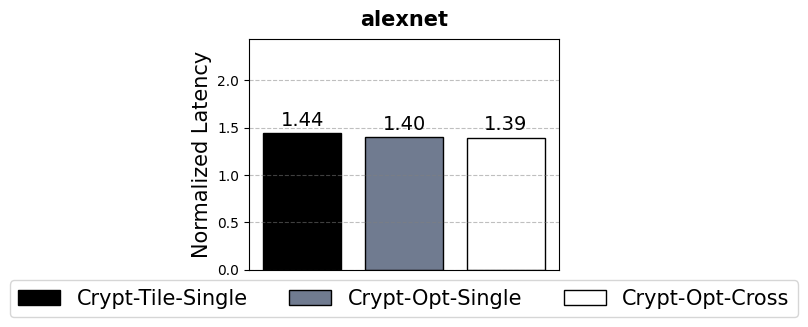

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_bar_graph(ax, data, labels, show_legend, title, show_ylabel):
    x_locations = np.arange(len(data))

    # Set the width of each bar
    num_groups = data.shape[0]
    num_bars = data.shape[1]
    bar_width = 1.0 / (num_bars + 3)
    space_width = 0.05
    
    # Set the x-axis positions for each group
    x_positions = np.arange(num_groups)

    ax.set_prop_cycle('color', plt.cm.bone(np.linspace(0, 1, num_bars)))
    
    # Define the hatch patterns to use for each bar
    hatch_patterns = ['.', '/', '\\', 'x', '-', '+']

    # Plot each group of bars
    for i in range(num_bars):
        # Calculate the x-axis positions for each bar within each group
        x_pos = x_positions + i * (bar_width + space_width)
        rects = ax.bar(x_pos, data[:, i], width=bar_width, align='edge', label=labels[i], edgecolor='black')

        # Add value of each bar as text
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points", ha='center', va='bottom', fontsize=14)

    # Remove the y-axis ticks
    ax.tick_params(axis='x', which='both', length=0, labelbottom=False)

    # Set the y-axis label
    if show_ylabel:
        ax.set_ylabel('Normalized Latency', fontsize=15)
    
    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)
    
    # Set the ylim
    max_val = data.max() + max((data.max() - data.min()) * 0.4, 1)
    ax.set_ylim(0, max_val)

    if show_legend:
        ax.legend(ncol=3, loc='lower center', fontsize=15, bbox_to_anchor=(0.5, -0.25))
        
    ax.set_title(title, fontsize=15, fontweight='bold', y=1.02)
    
fig, ax = plt.subplots(figsize=(4, 3))
plot_bar_graph(ax, np.asarray([float(cts_latency) / float(baseline_latency), \
                               float(cos_latency) / float(baseline_latency), \
                               float(coc_latency) / float(baseline_latency)]).reshape((1, 3)), \
               ['Crypt-Tile-Single', 'Crypt-Opt-Single', 'Crypt-Opt-Cross'], 
               True, model_name, True)

/tmp/ipykernel_467/13255952.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('bone', 4)


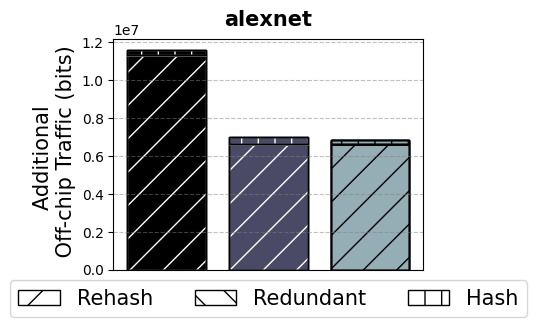

In [27]:
def plot_stacked_bar_graph(ax, data, labels, show_legend, title, ylog, show_ylabel):
    # Define the x locations for each group of bars
    x_locations = np.arange(len(data))

    # Set the width of each bar
    num_groups = data[0].shape[0]
    num_bars = data[0].shape[1]
    bar_width = 1.0 / (num_bars + 3)
    space_width = 0.05
    
    # Set the x-axis positions for each group
    x_positions = np.arange(num_groups)
    
    hatches = ['/', '\\', '|']
    cmap = plt.cm.get_cmap('bone', 4)
    
    # Plot each group of bars
    for i in range(num_bars):
        # Calculate the x-axis positions for each bar within each group
        x_pos = x_positions + i * (bar_width + space_width)
        bottom = np.zeros(num_bars)
        for j in range(len(data)):
            data_ = data[j]
            
            edgecolor = 'white' if i < 2 else 'black'
            ax.bar(x_pos, data_[:, i], width=bar_width, align='edge', edgecolor=edgecolor, hatch=hatches[j], \
                   bottom=bottom, color=cmap(i))
            ax.bar(x_pos, data_[:, i], width=bar_width, align='edge', edgecolor='black', \
                   bottom=bottom, color='none')
            bottom += data_[:, i]

    # Remove the y-axis ticks
    ax.tick_params(axis='x', which='both', length=0, labelbottom=False)

    # Set the ylim
    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)
    
    if ylog:
        ax.set_yscale('log')
        
    if show_ylabel:
        ax.set_ylabel('Additional \n Off-chip Traffic (bits)', fontsize=15)
        
    ax.set_title(title, fontsize=15, fontweight='bold', y=1.02)

    if show_legend:
        # Add the legend
        legend_elements = [plt.Rectangle((0, 0), 1, 1, facecolor='none', edgecolor='black', linewidth=1, hatch=hatches[i]) \
                           for i in range(len(data))]
        # legend_handles = [Patch(facecolor='white', edgecolor='white', hatch=hatches[i]) for i in range(len(hatches))]
        ax.legend(legend_elements, labels, \
                  ncol=3, bbox_to_anchor=(0.5, -0.25), loc='lower center', fontsize=15)
        
fig, ax = plt.subplots(figsize=(4, 3))
plot_stacked_bar_graph(ax, \
                       [np.asarray([cts_traffic[2], cos_traffic[2], coc_traffic[2]]).reshape((1, 3)), \
                        np.asarray([cts_traffic[0], cos_traffic[0], coc_traffic[0]]).reshape((1, 3)), \
                        np.asarray([cts_traffic[1], cos_traffic[1], coc_traffic[1]]).reshape((1, 3))], \
                        ['Rehash', 'Redundant', 'Hash'], True, model_name, False, True)